In [1]:
import numpy as np
import pandas as pd
import time
import math

import matplotlib.pyplot as plt
import seaborn as sns

import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoostRegressor
import optuna
from utils import generate_data
import pickle

from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('Berkeley_Solar.csv')
df.drop(columns={'Day of Year', 'Year', 'Month', 'Day', 'Visibility', 'Average Wind Speed (Period)'}, inplace=True)
df['Power Generated'] = df['Power Generated'] / 10000

In [3]:
df.head()

,First Hour of Period,Is Daylight,Distance to Solar Noon,Average Temperature (Day),Average Wind Direction (Day),Average Wind Speed (Day),Sky Cover,Relative Humidity,Average Barometric Pressure (Period),Power Generated
0,1,0,0.859897,69,28,7.5,0,75,29.82,0.0000
1,4,0,0.628535,69,28,7.5,0,77,29.85,0.0000
2,7,1,0.397172,69,28,7.5,0,70,29.89,0.5418
3,10,1,0.165810,69,28,7.5,0,33,29.91,2.5477
4,13,1,0.065553,69,28,7.5,0,21,29.89,3.0069


In [4]:
df.shape

(2920, 10)

In [5]:
features_time = ['Average Temperature (Day)', 'Average Wind Direction (Day)', 'Average Wind Speed (Day)', 'Relative Humidity', 
                         'Average Barometric Pressure (Period)', 'Power Generated']

In [6]:
lag_name = ['lag_temp', 'lag_wdirection', 'lag_wspeed', 'lag_humidity', 'lag_pressure', 'lag_Power']

In [7]:
y = 'Power Generated'

In [8]:
X_train_set, y_train_set, X_val_set, y_val_set, X_test_set, y_test_set = generate_data(df, features_time, lag_name, y)

## XGBoost

In [9]:
for i in range(len(X_train_set)):

    def xgb_model(trial):
        params = {
            'max_depth': trial.suggest_int('max_depth', 1, 9),
            'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 1.0),
            'n_estimators': trial.suggest_int('n_estimators', 50, 500),
            'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
            'gamma': trial.suggest_loguniform('gamma', 1e-8, 1.0),
            'subsample': trial.suggest_loguniform('subsample', 0.01, 1.0),
            'colsample_bytree': trial.suggest_loguniform('colsample_bytree', 0.01, 1.0),
            'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-8, 1.0),
            'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-8, 1.0),
        }
        # Fit the model
        optuna_model = xgb.XGBRegressor(**params)
        optuna_model.fit(X_train_set[i], y_train_set[i])

        # Make predictions
        y_predict = optuna_model.predict(X_val_set[i])

        # Evaluate predictions
        score = r2_score(y_val_set[i], y_predict)
        return score

    study = optuna.create_study(direction="maximize")
    study.optimize(xgb_model, n_trials=100)

    print("Number of finished trials: {}".format(len(study.trials)))
    print("Best trial:")
    trial = study.best_trial

    print(" Value: {}".format(trial.value))
    print(" Params:")
    for key, value in trial.params.items():
        print("  {}:{}".format(key, value))

    parameter = trial.params
    model_xgb = xgb.XGBRegressor(**parameter)
    model_xgb.fit(X_train_set[i], y_train_set[i])
    pickle.dump(model_xgb, open("./save_model/" + "xgb_{}.pickle.dat".format(i), "wb"))

[I 2023-06-22 12:08:29,185] A new study created in memory with name: no-name-cd1bc5cb-0a0e-45d4-9859-7c92fa04cbf7
[I 2023-06-22 12:08:29,330] Trial 0 finished with value: 0.8750586757449429 and parameters: {'max_depth': 6, 'learning_rate': 0.046794569035682756, 'n_estimators': 218, 'min_child_weight': 3, 'gamma': 0.0024261477801458195, 'subsample': 0.023725955972761757, 'colsample_bytree': 0.30884119532171944, 'reg_alpha': 0.038398767391911746, 'reg_lambda': 0.00853538350447194}. Best is trial 0 with value: 0.8750586757449429.
[I 2023-06-22 12:08:29,377] Trial 1 finished with value: 0.8619143443285507 and parameters: {'max_depth': 7, 'learning_rate': 0.04882154297793743, 'n_estimators': 94, 'min_child_weight': 7, 'gamma': 0.00010118218383034309, 'subsample': 0.05377583043834153, 'colsample_bytree': 0.068784639259211, 'reg_alpha': 5.454171230233502e-08, 'reg_lambda': 0.0028632818142078067}. Best is trial 0 with value: 0.8750586757449429.
[I 2023-06-22 12:08:29,433] Trial 2 finished with

[I 2023-06-22 12:08:32,010] Trial 20 finished with value: 0.883297588925313 and parameters: {'max_depth': 4, 'learning_rate': 0.029849583540655998, 'n_estimators': 432, 'min_child_weight': 2, 'gamma': 1.96162672332219e-06, 'subsample': 0.09374217650659428, 'colsample_bytree': 0.011082594955613256, 'reg_alpha': 4.0366170560204375e-07, 'reg_lambda': 0.001054894515228444}. Best is trial 18 with value: 0.8972605437365663.
[I 2023-06-22 12:08:32,160] Trial 21 finished with value: 0.8256941007880606 and parameters: {'max_depth': 2, 'learning_rate': 0.011814195040941786, 'n_estimators': 343, 'min_child_weight': 4, 'gamma': 0.00108280512927414, 'subsample': 0.03831773840800768, 'colsample_bytree': 0.037003738298623405, 'reg_alpha': 1.4208983760672552e-05, 'reg_lambda': 0.00011706090738929643}. Best is trial 18 with value: 0.8972605437365663.
[I 2023-06-22 12:08:32,290] Trial 22 finished with value: 0.7704448261871543 and parameters: {'max_depth': 2, 'learning_rate': 0.010284442047774204, 'n_es

[I 2023-06-22 12:08:35,793] Trial 40 finished with value: 0.8559996237238752 and parameters: {'max_depth': 7, 'learning_rate': 0.05030499943416911, 'n_estimators': 499, 'min_child_weight': 3, 'gamma': 0.09947787270756848, 'subsample': 0.08924639110412143, 'colsample_bytree': 0.024990398538206487, 'reg_alpha': 7.538324293464672e-07, 'reg_lambda': 0.0023229869978876}. Best is trial 35 with value: 0.9053673777630687.
[I 2023-06-22 12:08:35,940] Trial 41 finished with value: 0.9022605722681867 and parameters: {'max_depth': 3, 'learning_rate': 0.05567906015357098, 'n_estimators': 308, 'min_child_weight': 7, 'gamma': 0.3309858363216912, 'subsample': 0.04079453707636906, 'colsample_bytree': 0.04906398829185915, 'reg_alpha': 9.038271011566876e-05, 'reg_lambda': 4.0232584809937195e-05}. Best is trial 35 with value: 0.9053673777630687.
[I 2023-06-22 12:08:36,081] Trial 42 finished with value: 0.903683605919237 and parameters: {'max_depth': 3, 'learning_rate': 0.08002229380055931, 'n_estimators':

[I 2023-06-22 12:08:38,122] Trial 60 finished with value: 0.9116308266628199 and parameters: {'max_depth': 2, 'learning_rate': 0.18348343818114712, 'n_estimators': 115, 'min_child_weight': 4, 'gamma': 0.008540357501005241, 'subsample': 0.06261680528403611, 'colsample_bytree': 0.03232912432803762, 'reg_alpha': 0.00039896278243687505, 'reg_lambda': 3.623589759886467e-07}. Best is trial 56 with value: 0.923029115311484.
[I 2023-06-22 12:08:38,206] Trial 61 finished with value: 0.8979570518433007 and parameters: {'max_depth': 2, 'learning_rate': 0.10765271687879467, 'n_estimators': 104, 'min_child_weight': 4, 'gamma': 0.005124003165702607, 'subsample': 0.06031392182724982, 'colsample_bytree': 0.032793837816242934, 'reg_alpha': 0.0002889816770826343, 'reg_lambda': 2.3631612258710125e-07}. Best is trial 56 with value: 0.923029115311484.
[I 2023-06-22 12:08:38,280] Trial 62 finished with value: 0.9068989201266566 and parameters: {'max_depth': 2, 'learning_rate': 0.17151505670873024, 'n_estima

[I 2023-06-22 12:08:39,842] Trial 80 finished with value: 0.9098049784607418 and parameters: {'max_depth': 3, 'learning_rate': 0.18898269020497063, 'n_estimators': 76, 'min_child_weight': 3, 'gamma': 0.007532094261013033, 'subsample': 0.05199854670180301, 'colsample_bytree': 0.03062038659317472, 'reg_alpha': 0.001922909425183038, 'reg_lambda': 7.05063686689874e-07}. Best is trial 56 with value: 0.923029115311484.
[I 2023-06-22 12:08:39,925] Trial 81 finished with value: 0.9024689964985807 and parameters: {'max_depth': 2, 'learning_rate': 0.148523717013685, 'n_estimators': 88, 'min_child_weight': 4, 'gamma': 0.002026669342218587, 'subsample': 0.06480831891919255, 'colsample_bytree': 0.02298339045335524, 'reg_alpha': 0.0001016162451788849, 'reg_lambda': 3.6793657742181184e-07}. Best is trial 56 with value: 0.923029115311484.
[I 2023-06-22 12:08:40,047] Trial 82 finished with value: 0.8967898968142247 and parameters: {'max_depth': 2, 'learning_rate': 0.1557070802575694, 'n_estimators': 19

[I 2023-06-22 12:08:41,802] A new study created in memory with name: no-name-023e165d-b345-438b-93bd-43069f4c9b04


Number of finished trials: 100
Best trial:
 Value: 0.923029115311484
 Params:
  max_depth:2
  learning_rate:0.09427160245717789
  n_estimators:156
  min_child_weight:4
  gamma:0.029337963383951893
  subsample:0.04592021003774596
  colsample_bytree:0.028706991691861167
  reg_alpha:4.538126223099991e-05
  reg_lambda:1.48368008112771e-06


[I 2023-06-22 12:08:42,042] Trial 0 finished with value: 0.908433479077933 and parameters: {'max_depth': 8, 'learning_rate': 0.08277409828130748, 'n_estimators': 437, 'min_child_weight': 4, 'gamma': 0.0002383342096351858, 'subsample': 0.5460448914434116, 'colsample_bytree': 0.022327587510974287, 'reg_alpha': 2.441892334020768e-08, 'reg_lambda': 0.028480620224872393}. Best is trial 0 with value: 0.908433479077933.
[I 2023-06-22 12:08:42,201] Trial 1 finished with value: 0.9007519075607552 and parameters: {'max_depth': 2, 'learning_rate': 0.016923143647715397, 'n_estimators': 445, 'min_child_weight': 9, 'gamma': 0.23705926270208977, 'subsample': 0.5861809210033674, 'colsample_bytree': 0.098842485208065, 'reg_alpha': 1.3597215127520253e-05, 'reg_lambda': 0.03409530149029807}. Best is trial 0 with value: 0.908433479077933.
[I 2023-06-22 12:08:42,232] Trial 2 finished with value: 0.4050563701616474 and parameters: {'max_depth': 5, 'learning_rate': 0.02986770539952349, 'n_estimators': 58, 'm

[I 2023-06-22 12:08:44,853] Trial 20 finished with value: 0.9220537513836944 and parameters: {'max_depth': 1, 'learning_rate': 0.12430112146954285, 'n_estimators': 307, 'min_child_weight': 2, 'gamma': 0.16441466094951318, 'subsample': 0.9223846729376136, 'colsample_bytree': 0.014555104370851795, 'reg_alpha': 6.369821365144175e-05, 'reg_lambda': 4.222220084520532e-05}. Best is trial 7 with value: 0.9280154337692095.
[I 2023-06-22 12:08:45,051] Trial 21 finished with value: 0.9222377872729828 and parameters: {'max_depth': 3, 'learning_rate': 0.026950230452230366, 'n_estimators': 460, 'min_child_weight': 8, 'gamma': 0.0010918221677157823, 'subsample': 0.149871007631724, 'colsample_bytree': 0.04297337499387609, 'reg_alpha': 8.209645529987603e-08, 'reg_lambda': 0.0004505349679926192}. Best is trial 7 with value: 0.9280154337692095.
[I 2023-06-22 12:08:45,228] Trial 22 finished with value: 0.9226535500579691 and parameters: {'max_depth': 3, 'learning_rate': 0.025680991183183333, 'n_estimator

[I 2023-06-22 12:08:48,696] Trial 40 finished with value: 0.9022083060800042 and parameters: {'max_depth': 2, 'learning_rate': 0.5151663623174143, 'n_estimators': 386, 'min_child_weight': 4, 'gamma': 1.0947207301982789e-05, 'subsample': 0.4545127174646467, 'colsample_bytree': 0.03569055110042616, 'reg_alpha': 2.041487273455179e-05, 'reg_lambda': 0.1950138596089245}. Best is trial 33 with value: 0.9319019018219021.
[I 2023-06-22 12:08:48,903] Trial 41 finished with value: 0.9258008278480826 and parameters: {'max_depth': 3, 'learning_rate': 0.27860066929183785, 'n_estimators': 427, 'min_child_weight': 2, 'gamma': 0.001171750171851655, 'subsample': 0.7599516027617097, 'colsample_bytree': 0.02595175922893534, 'reg_alpha': 2.635570638284272e-05, 'reg_lambda': 0.05884665838264219}. Best is trial 33 with value: 0.9319019018219021.
[I 2023-06-22 12:08:49,105] Trial 42 finished with value: 0.9278996034090301 and parameters: {'max_depth': 3, 'learning_rate': 0.2853648187635595, 'n_estimators': 4

[I 2023-06-22 12:08:52,429] Trial 60 finished with value: 0.9311171900347351 and parameters: {'max_depth': 1, 'learning_rate': 0.3802515137376204, 'n_estimators': 485, 'min_child_weight': 3, 'gamma': 0.004458726032769365, 'subsample': 0.6212671675959028, 'colsample_bytree': 0.0803072202281583, 'reg_alpha': 8.436371976486889e-07, 'reg_lambda': 0.9493664128396818}. Best is trial 56 with value: 0.9342872644619016.
[I 2023-06-22 12:08:52,613] Trial 61 finished with value: 0.9317134703675902 and parameters: {'max_depth': 1, 'learning_rate': 0.37421865970843543, 'n_estimators': 484, 'min_child_weight': 3, 'gamma': 0.003432614774623749, 'subsample': 0.5926345036447754, 'colsample_bytree': 0.08392297275867426, 'reg_alpha': 6.296178283617218e-07, 'reg_lambda': 0.37854986116351125}. Best is trial 56 with value: 0.9342872644619016.
[I 2023-06-22 12:08:52,788] Trial 62 finished with value: 0.9302367852330529 and parameters: {'max_depth': 1, 'learning_rate': 0.4073135418243548, 'n_estimators': 458,

[I 2023-06-22 12:08:56,218] Trial 80 finished with value: 0.905419317893674 and parameters: {'max_depth': 2, 'learning_rate': 0.7974902309178211, 'n_estimators': 442, 'min_child_weight': 2, 'gamma': 0.005396658819948455, 'subsample': 0.9997911512905125, 'colsample_bytree': 0.08179114285301221, 'reg_alpha': 2.54196171476946e-06, 'reg_lambda': 0.05175970334702683}. Best is trial 56 with value: 0.9342872644619016.
[I 2023-06-22 12:08:56,407] Trial 81 finished with value: 0.9306513495406727 and parameters: {'max_depth': 1, 'learning_rate': 0.40955824922590406, 'n_estimators': 484, 'min_child_weight': 3, 'gamma': 0.00419592756472445, 'subsample': 0.6354832313913402, 'colsample_bytree': 0.07910298212884735, 'reg_alpha': 1.0913025028161457e-06, 'reg_lambda': 0.9243308789946473}. Best is trial 56 with value: 0.9342872644619016.
[I 2023-06-22 12:08:56,591] Trial 82 finished with value: 0.9339237311396226 and parameters: {'max_depth': 1, 'learning_rate': 0.38502412174931283, 'n_estimators': 475,

[I 2023-06-22 12:08:59,844] A new study created in memory with name: no-name-382511fc-a32c-47cc-a21e-1ffda8320677
[I 2023-06-22 12:08:59,885] Trial 0 finished with value: 0.6773446893480459 and parameters: {'max_depth': 3, 'learning_rate': 0.027716709572192536, 'n_estimators': 114, 'min_child_weight': 8, 'gamma': 0.09419401995853115, 'subsample': 0.05398880865582647, 'colsample_bytree': 0.013369425071757014, 'reg_alpha': 0.0019469890779234003, 'reg_lambda': 2.484870131592592e-05}. Best is trial 0 with value: 0.6773446893480459.


Number of finished trials: 100
Best trial:
 Value: 0.93739746724234
 Params:
  max_depth:1
  learning_rate:0.4935389861656871
  n_estimators:476
  min_child_weight:3
  gamma:0.00034505811556889677
  subsample:0.5528406022968089
  colsample_bytree:0.07044227507589455
  reg_alpha:3.741836098792789e-07
  reg_lambda:0.02625400849582396


[I 2023-06-22 12:09:00,028] Trial 1 finished with value: 0.8489651200265732 and parameters: {'max_depth': 9, 'learning_rate': 0.08178217732628766, 'n_estimators': 363, 'min_child_weight': 3, 'gamma': 0.6230395183141152, 'subsample': 0.014114933361326503, 'colsample_bytree': 0.6041544758479815, 'reg_alpha': 0.018641157411547996, 'reg_lambda': 8.011383819687912e-05}. Best is trial 1 with value: 0.8489651200265732.
[I 2023-06-22 12:09:00,184] Trial 2 finished with value: 0.8533577949147878 and parameters: {'max_depth': 6, 'learning_rate': 0.13900312161138847, 'n_estimators': 456, 'min_child_weight': 9, 'gamma': 0.0007730283661743877, 'subsample': 0.05571624815573155, 'colsample_bytree': 0.10936185512817344, 'reg_alpha': 2.700905733549095e-06, 'reg_lambda': 0.015855644714987648}. Best is trial 2 with value: 0.8533577949147878.
[I 2023-06-22 12:09:00,309] Trial 3 finished with value: 0.8684658658481829 and parameters: {'max_depth': 9, 'learning_rate': 0.5416134347962513, 'n_estimators': 147

[I 2023-06-22 12:09:02,800] Trial 21 finished with value: 0.9075373721920736 and parameters: {'max_depth': 2, 'learning_rate': 0.01924126120882189, 'n_estimators': 416, 'min_child_weight': 4, 'gamma': 0.12989102926198118, 'subsample': 0.12136826943333372, 'colsample_bytree': 0.9969162027239334, 'reg_alpha': 4.420481488276622e-07, 'reg_lambda': 0.00037773562473480016}. Best is trial 16 with value: 0.917615474511379.
[I 2023-06-22 12:09:02,966] Trial 22 finished with value: 0.9051702727219566 and parameters: {'max_depth': 2, 'learning_rate': 0.018247506733566805, 'n_estimators': 383, 'min_child_weight': 3, 'gamma': 0.09076663712600923, 'subsample': 0.2786564659606462, 'colsample_bytree': 0.6232084319560152, 'reg_alpha': 6.695191611354401e-07, 'reg_lambda': 0.0010030923541909896}. Best is trial 16 with value: 0.917615474511379.
[I 2023-06-22 12:09:03,188] Trial 23 finished with value: 0.9140442535007538 and parameters: {'max_depth': 3, 'learning_rate': 0.029460821835802335, 'n_estimators'

[I 2023-06-22 12:09:07,579] Trial 41 finished with value: 0.9217598614496698 and parameters: {'max_depth': 8, 'learning_rate': 0.013730709239033344, 'n_estimators': 443, 'min_child_weight': 10, 'gamma': 0.2506789370949135, 'subsample': 0.3153780284678822, 'colsample_bytree': 0.7677291547190821, 'reg_alpha': 1.192253030415095e-07, 'reg_lambda': 1.1898219501825108e-05}. Best is trial 41 with value: 0.9217598614496698.
[I 2023-06-22 12:09:07,872] Trial 42 finished with value: 0.9197519526500335 and parameters: {'max_depth': 8, 'learning_rate': 0.01256324464231748, 'n_estimators': 439, 'min_child_weight': 10, 'gamma': 0.30315885806099024, 'subsample': 0.23502014637734256, 'colsample_bytree': 0.7906885186171346, 'reg_alpha': 1.5521667117979103e-07, 'reg_lambda': 1.3427912290099494e-05}. Best is trial 41 with value: 0.9217598614496698.
[I 2023-06-22 12:09:08,210] Trial 43 finished with value: 0.921906462236705 and parameters: {'max_depth': 8, 'learning_rate': 0.013638062115412259, 'n_estimat

[I 2023-06-22 12:09:13,135] Trial 61 finished with value: 0.9216250643813566 and parameters: {'max_depth': 7, 'learning_rate': 0.011437937104870809, 'n_estimators': 429, 'min_child_weight': 9, 'gamma': 0.5211077111094956, 'subsample': 0.33993905821929915, 'colsample_bytree': 0.6174435700255095, 'reg_alpha': 1.2352322207478886e-06, 'reg_lambda': 1.9975309378308684e-06}. Best is trial 55 with value: 0.9245005335975472.
[I 2023-06-22 12:09:13,445] Trial 62 finished with value: 0.9218029879599973 and parameters: {'max_depth': 7, 'learning_rate': 0.011619271391935372, 'n_estimators': 447, 'min_child_weight': 9, 'gamma': 0.44196195174197783, 'subsample': 0.35779860099940314, 'colsample_bytree': 0.5853612205097961, 'reg_alpha': 4.737409676728465e-07, 'reg_lambda': 7.621428964766279e-06}. Best is trial 55 with value: 0.9245005335975472.
[I 2023-06-22 12:09:13,791] Trial 63 finished with value: 0.922355625462105 and parameters: {'max_depth': 8, 'learning_rate': 0.011688818166066206, 'n_estimato

[I 2023-06-22 12:09:19,013] Trial 81 finished with value: 0.9202597381891778 and parameters: {'max_depth': 9, 'learning_rate': 0.01092062955935507, 'n_estimators': 411, 'min_child_weight': 10, 'gamma': 0.034128111952093476, 'subsample': 0.44100322190774766, 'colsample_bytree': 0.742464019473371, 'reg_alpha': 3.224524031503356e-08, 'reg_lambda': 1.5037598828276468e-06}. Best is trial 75 with value: 0.9249697972180644.
[I 2023-06-22 12:09:19,258] Trial 82 finished with value: 0.9199595808525882 and parameters: {'max_depth': 9, 'learning_rate': 0.012605298150699554, 'n_estimators': 332, 'min_child_weight': 10, 'gamma': 0.011108797731549932, 'subsample': 0.2379689265221329, 'colsample_bytree': 0.6913616318468498, 'reg_alpha': 2.4414409302904856e-08, 'reg_lambda': 3.8373020300384437e-07}. Best is trial 75 with value: 0.9249697972180644.
[I 2023-06-22 12:09:19,610] Trial 83 finished with value: 0.919457229955144 and parameters: {'max_depth': 9, 'learning_rate': 0.013107368254320647, 'n_estim

Number of finished trials: 100
Best trial:
 Value: 0.9249697972180644
 Params:
  max_depth:9
  learning_rate:0.01032476796408865
  n_estimators:414
  min_child_weight:10
  gamma:0.011139968175669361
  subsample:0.2886356760572905
  colsample_bytree:0.9480940140815423
  reg_alpha:2.223935842597659e-08
  reg_lambda:1.5952059603670156e-06


In [10]:
def predict_test(model_name, X_test_set, y_test_set):

    r2 = []
    mse = []
    mae = []
    pre_results = []

    for i in range(len(X_test_set)):
        model = pickle.load(open("./save_model/"+"/"+model_name+"_{}".format(i)+".pickle.dat", "rb"))
        prediction = model.predict(X_test_set[i])
        r2_i = r2_score(prediction, y_test_set[i])
        mse_i = mean_squared_error(prediction, y_test_set[i])
        mae_i = mean_absolute_error(prediction, y_test_set[i])
        r2.append(r2_i)
        mse.append(mse_i)
        mae.append(mae_i)
        pre_results.append(prediction)

    return r2, mse, mae, pre_results


xgb_r2, xgb_mse, xgb_mae, xgb_pred = predict_test('xgb', X_test_set, y_test_set)
print(xgb_r2, xgb_mse, xgb_mae)

[0.8950507584798925, 0.8803081056372831, 0.9365812246322087] [0.11863661393256535, 0.14889117184542452, 0.08952892288573829] [0.24364589365505213, 0.26533592627706626, 0.14293246386353198]


## LightGBM

In [11]:
for i in range(len(X_train_set)):

    def lgb_model(trial):
        params = {
            'max_depth': trial.suggest_int('max_depth', 1, 9),
            'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 1.0),
            'n_estimators': trial.suggest_int('n_estimators', 50, 500),
            'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
            'subsample': trial.suggest_loguniform('subsample', 0.01, 1.0),
            'colsample_bytree': trial.suggest_loguniform('colsample_bytree', 0.01, 1.0),
            'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-8, 1.0),
            'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-8, 1.0),
        }
        # Fit the model
        optuna_model = lgb.LGBMRegressor(**params)
        optuna_model.fit(X_train_set[i], y_train_set[i])

        # Make predictions
        y_predict = optuna_model.predict(X_val_set[i])

        # Evaluate predictions
        score = r2_score(y_val_set[i], y_predict)
        return score

    study = optuna.create_study(direction="maximize")
    study.optimize(lgb_model, n_trials=100)

    print("Number of finished trials: {}".format(len(study.trials)))
    print("Best trial:")
    trial = study.best_trial

    print(" Value: {}".format(trial.value))
    print(" Params:")
    for key, value in trial.params.items():
        print("  {}:{}".format(key, value))

    parameter = trial.params
    model_lgb = lgb.LGBMRegressor(**parameter)
    model_lgb.fit(X_train_set[i], y_train_set[i])
    pickle.dump(model_lgb, open("./save_model/"+"/lgb_{}.pickle.dat".format(i), "wb"))

[I 2023-06-22 12:09:34,292] A new study created in memory with name: no-name-413b8442-1339-4c70-af8f-130f2115876f
[I 2023-06-22 12:09:34,382] Trial 0 finished with value: 0.875993632789137 and parameters: {'max_depth': 7, 'learning_rate': 0.02141338987190965, 'n_estimators': 348, 'min_child_weight': 8, 'subsample': 0.3730801285514152, 'colsample_bytree': 0.06153494295918495, 'reg_alpha': 0.31662237387865166, 'reg_lambda': 0.007517765190784668}. Best is trial 0 with value: 0.875993632789137.
[I 2023-06-22 12:09:34,428] Trial 1 finished with value: 0.879489087619858 and parameters: {'max_depth': 4, 'learning_rate': 0.029646114428318934, 'n_estimators': 348, 'min_child_weight': 8, 'subsample': 0.011091729582689332, 'colsample_bytree': 0.01048691473827114, 'reg_alpha': 1.6228558296734962e-08, 'reg_lambda': 0.001894317935629736}. Best is trial 1 with value: 0.879489087619858.
[I 2023-06-22 12:09:34,441] Trial 2 finished with value: 0.42580328576321314 and parameters: {'max_depth': 1, 'learn

[I 2023-06-22 12:09:35,658] Trial 21 finished with value: 0.9011201432715743 and parameters: {'max_depth': 6, 'learning_rate': 0.010062637236159008, 'n_estimators': 262, 'min_child_weight': 4, 'subsample': 0.30406463422927615, 'colsample_bytree': 0.45605502624034033, 'reg_alpha': 8.535788957316669e-08, 'reg_lambda': 1.0262347547990277e-08}. Best is trial 15 with value: 0.9193009856520525.
[I 2023-06-22 12:09:35,753] Trial 22 finished with value: 0.8963791082160184 and parameters: {'max_depth': 6, 'learning_rate': 0.029895543724428972, 'n_estimators': 259, 'min_child_weight': 4, 'subsample': 0.5431605634503391, 'colsample_bytree': 0.43862310534530335, 'reg_alpha': 1.4258585932922883e-08, 'reg_lambda': 1.1506934921648345e-08}. Best is trial 15 with value: 0.9193009856520525.
[I 2023-06-22 12:09:35,849] Trial 23 finished with value: 0.8921800133023465 and parameters: {'max_depth': 8, 'learning_rate': 0.017081546253074, 'n_estimators': 180, 'min_child_weight': 2, 'subsample': 0.26301979543

[I 2023-06-22 12:09:37,470] Trial 43 finished with value: 0.9065247864631479 and parameters: {'max_depth': 9, 'learning_rate': 0.06382044254284967, 'n_estimators': 66, 'min_child_weight': 2, 'subsample': 0.46725930135591903, 'colsample_bytree': 0.5033612736484069, 'reg_alpha': 1.0391183505930977e-08, 'reg_lambda': 1.6446323851367904e-08}. Best is trial 15 with value: 0.9193009856520525.
[I 2023-06-22 12:09:37,550] Trial 44 finished with value: 0.896502946940239 and parameters: {'max_depth': 9, 'learning_rate': 0.023422224034477187, 'n_estimators': 125, 'min_child_weight': 1, 'subsample': 0.7867017168302411, 'colsample_bytree': 0.9198090301612504, 'reg_alpha': 4.950568840123673e-07, 'reg_lambda': 1.3964050477958348e-07}. Best is trial 15 with value: 0.9193009856520525.
[I 2023-06-22 12:09:37,597] Trial 45 finished with value: 0.6433645436059603 and parameters: {'max_depth': 1, 'learning_rate': 0.017278495583887436, 'n_estimators': 54, 'min_child_weight': 4, 'subsample': 0.39924673360740

[I 2023-06-22 12:09:39,149] Trial 65 finished with value: 0.8041430711236423 and parameters: {'max_depth': 6, 'learning_rate': 0.01632340142420596, 'n_estimators': 63, 'min_child_weight': 2, 'subsample': 0.12516996680504727, 'colsample_bytree': 0.4109527582832692, 'reg_alpha': 9.928564734510245e-07, 'reg_lambda': 3.136417293765879e-06}. Best is trial 53 with value: 0.9200816611042268.
[I 2023-06-22 12:09:39,221] Trial 66 finished with value: 0.9094430822499863 and parameters: {'max_depth': 7, 'learning_rate': 0.02610549689548867, 'n_estimators': 100, 'min_child_weight': 2, 'subsample': 0.15698828472334828, 'colsample_bytree': 0.47003911688742994, 'reg_alpha': 1.8252767269558518e-07, 'reg_lambda': 2.132879715564587e-05}. Best is trial 53 with value: 0.9200816611042268.
[I 2023-06-22 12:09:39,289] Trial 67 finished with value: 0.8972732478800486 and parameters: {'max_depth': 3, 'learning_rate': 0.03649025450122904, 'n_estimators': 241, 'min_child_weight': 3, 'subsample': 0.28411292183243

[I 2023-06-22 12:09:40,924] Trial 87 finished with value: 0.8916337478166685 and parameters: {'max_depth': 7, 'learning_rate': 0.01901624258788789, 'n_estimators': 455, 'min_child_weight': 9, 'subsample': 0.2459739579799748, 'colsample_bytree': 0.5063340370161561, 'reg_alpha': 7.163011405835737e-06, 'reg_lambda': 2.0698328521888512e-07}. Best is trial 53 with value: 0.9200816611042268.
[I 2023-06-22 12:09:40,988] Trial 88 finished with value: 0.8894398588493343 and parameters: {'max_depth': 9, 'learning_rate': 0.03496807720582659, 'n_estimators': 60, 'min_child_weight': 3, 'subsample': 0.27406802248354706, 'colsample_bytree': 0.308565487523992, 'reg_alpha': 1.394814240689715e-07, 'reg_lambda': 1.4915468751940916e-06}. Best is trial 53 with value: 0.9200816611042268.
[I 2023-06-22 12:09:41,079] Trial 89 finished with value: 0.8881930659318751 and parameters: {'max_depth': 5, 'learning_rate': 0.024077758136558162, 'n_estimators': 228, 'min_child_weight': 5, 'subsample': 0.334371568737621

Number of finished trials: 100
Best trial:
 Value: 0.9200816611042268
 Params:
  max_depth:9
  learning_rate:0.047501134804319375
  n_estimators:50
  min_child_weight:1
  subsample:0.16808020562087336
  colsample_bytree:0.35822280368396237
  reg_alpha:6.458521753927977e-07
  reg_lambda:2.0050276776519737e-06


[I 2023-06-22 12:09:42,068] Trial 5 finished with value: 0.9361561388004376 and parameters: {'max_depth': 1, 'learning_rate': 0.8079534016710979, 'n_estimators': 350, 'min_child_weight': 5, 'subsample': 0.18658149069338983, 'colsample_bytree': 0.22027620477287446, 'reg_alpha': 4.555568482429284e-05, 'reg_lambda': 6.547282471757437e-08}. Best is trial 5 with value: 0.9361561388004376.
[I 2023-06-22 12:09:42,095] Trial 6 finished with value: 0.9187915434036236 and parameters: {'max_depth': 2, 'learning_rate': 0.030890959169148042, 'n_estimators': 331, 'min_child_weight': 10, 'subsample': 0.015958762435152776, 'colsample_bytree': 0.14335460373282985, 'reg_alpha': 0.5433180777889459, 'reg_lambda': 0.05788647709661228}. Best is trial 5 with value: 0.9361561388004376.
[I 2023-06-22 12:09:42,149] Trial 7 finished with value: 0.9371069593011986 and parameters: {'max_depth': 9, 'learning_rate': 0.3963523284490355, 'n_estimators': 192, 'min_child_weight': 6, 'subsample': 0.9205361131191342, 'col

[I 2023-06-22 12:09:43,517] Trial 27 finished with value: 0.9535616968038706 and parameters: {'max_depth': 3, 'learning_rate': 0.12624665280304243, 'n_estimators': 93, 'min_child_weight': 4, 'subsample': 0.061033053434582936, 'colsample_bytree': 0.4048789833874351, 'reg_alpha': 0.00014325344171202831, 'reg_lambda': 7.108788549239904e-05}. Best is trial 17 with value: 0.9572719255646306.
[I 2023-06-22 12:09:43,604] Trial 28 finished with value: 0.9466981528880988 and parameters: {'max_depth': 8, 'learning_rate': 0.07324926685352018, 'n_estimators': 207, 'min_child_weight': 2, 'subsample': 0.10699617272026159, 'colsample_bytree': 0.23400573613930536, 'reg_alpha': 1.9483876080363452e-07, 'reg_lambda': 0.006121593288253213}. Best is trial 17 with value: 0.9572719255646306.
[I 2023-06-22 12:09:43,672] Trial 29 finished with value: 0.8154777436391153 and parameters: {'max_depth': 5, 'learning_rate': 0.010209893774136619, 'n_estimators': 138, 'min_child_weight': 7, 'subsample': 0.142567234854

[I 2023-06-22 12:09:45,188] Trial 49 finished with value: 0.9391081368473865 and parameters: {'max_depth': 2, 'learning_rate': 0.013077055717280073, 'n_estimators': 264, 'min_child_weight': 4, 'subsample': 0.3601986568095359, 'colsample_bytree': 0.9841166242269315, 'reg_alpha': 1.1088728194531329e-08, 'reg_lambda': 1.7907994806685616e-05}. Best is trial 33 with value: 0.9603529194591802.
[I 2023-06-22 12:09:45,249] Trial 50 finished with value: 0.9450781531010229 and parameters: {'max_depth': 3, 'learning_rate': 0.018283434639627894, 'n_estimators': 178, 'min_child_weight': 10, 'subsample': 0.5002417983772073, 'colsample_bytree': 0.391284415963431, 'reg_alpha': 6.790188109406796e-08, 'reg_lambda': 8.817984846703645e-07}. Best is trial 33 with value: 0.9603529194591802.
[I 2023-06-22 12:09:45,331] Trial 51 finished with value: 0.9581309071620133 and parameters: {'max_depth': 5, 'learning_rate': 0.02528596093618194, 'n_estimators': 228, 'min_child_weight': 1, 'subsample': 0.2352237205266

[I 2023-06-22 12:09:47,078] Trial 71 finished with value: 0.9602528108041302 and parameters: {'max_depth': 4, 'learning_rate': 0.015740009371774003, 'n_estimators': 342, 'min_child_weight': 2, 'subsample': 0.46084935701931895, 'colsample_bytree': 0.9152028688260463, 'reg_alpha': 2.2899327951718994e-08, 'reg_lambda': 0.00028828325214658987}. Best is trial 65 with value: 0.96068647711938.
[I 2023-06-22 12:09:47,166] Trial 72 finished with value: 0.9595358803543503 and parameters: {'max_depth': 4, 'learning_rate': 0.015153030055738408, 'n_estimators': 316, 'min_child_weight': 1, 'subsample': 0.5183214740228632, 'colsample_bytree': 0.9859979379745741, 'reg_alpha': 2.0902382050514792e-08, 'reg_lambda': 0.00014101178528225626}. Best is trial 65 with value: 0.96068647711938.
[I 2023-06-22 12:09:47,263] Trial 73 finished with value: 0.9606966630954468 and parameters: {'max_depth': 4, 'learning_rate': 0.015324241973303137, 'n_estimators': 399, 'min_child_weight': 1, 'subsample': 0.5462138568002

[I 2023-06-22 12:09:49,056] Trial 93 finished with value: 0.9602345667181531 and parameters: {'max_depth': 4, 'learning_rate': 0.012393808018164131, 'n_estimators': 371, 'min_child_weight': 1, 'subsample': 0.5390393935038266, 'colsample_bytree': 0.6840925646664908, 'reg_alpha': 1.6944697565034148e-07, 'reg_lambda': 8.559356826920646e-05}. Best is trial 73 with value: 0.9606966630954468.
[I 2023-06-22 12:09:49,149] Trial 94 finished with value: 0.9572416901525235 and parameters: {'max_depth': 4, 'learning_rate': 0.011593264291467092, 'n_estimators': 338, 'min_child_weight': 2, 'subsample': 0.5595018249438725, 'colsample_bytree': 0.6137563008060473, 'reg_alpha': 1.6935732676161422e-07, 'reg_lambda': 0.00010079840488735438}. Best is trial 73 with value: 0.9606966630954468.
[I 2023-06-22 12:09:49,268] Trial 95 finished with value: 0.9588918916752234 and parameters: {'max_depth': 5, 'learning_rate': 0.012668388769406902, 'n_estimators': 399, 'min_child_weight': 1, 'subsample': 0.60730064599

Number of finished trials: 100
Best trial:
 Value: 0.9606966630954468
 Params:
  max_depth:4
  learning_rate:0.015324241973303137
  n_estimators:399
  min_child_weight:1
  subsample:0.5462138568002299
  colsample_bytree:0.6836695013380268
  reg_alpha:3.6138103935587606e-07
  reg_lambda:0.0002695389826885238


[I 2023-06-22 12:09:49,910] Trial 3 finished with value: 0.8844893722436747 and parameters: {'max_depth': 5, 'learning_rate': 0.5543859758903621, 'n_estimators': 229, 'min_child_weight': 7, 'subsample': 0.1400535276981777, 'colsample_bytree': 0.4881089260338153, 'reg_alpha': 0.016602426725810138, 'reg_lambda': 0.12483380310980843}. Best is trial 0 with value: 0.896599768266657.
[I 2023-06-22 12:09:49,966] Trial 4 finished with value: 0.8386018390206313 and parameters: {'max_depth': 7, 'learning_rate': 0.13826270077794603, 'n_estimators': 300, 'min_child_weight': 1, 'subsample': 0.9334493771505488, 'colsample_bytree': 0.014012857624434745, 'reg_alpha': 0.0004918638022287943, 'reg_lambda': 6.602369222259103e-07}. Best is trial 0 with value: 0.896599768266657.
[I 2023-06-22 12:09:49,988] Trial 5 finished with value: 0.8679819606408825 and parameters: {'max_depth': 1, 'learning_rate': 0.6476258406425156, 'n_estimators': 327, 'min_child_weight': 4, 'subsample': 0.2620926456946862, 'colsampl

[I 2023-06-22 12:09:51,546] Trial 25 finished with value: 0.9119229840186811 and parameters: {'max_depth': 8, 'learning_rate': 0.010043529493660542, 'n_estimators': 250, 'min_child_weight': 8, 'subsample': 0.04310055694044113, 'colsample_bytree': 0.7624136665491487, 'reg_alpha': 8.297315354814208e-06, 'reg_lambda': 5.592276946224968e-07}. Best is trial 10 with value: 0.9211316026542707.
[I 2023-06-22 12:09:51,655] Trial 26 finished with value: 0.9181874287851646 and parameters: {'max_depth': 6, 'learning_rate': 0.016913704905654553, 'n_estimators': 328, 'min_child_weight': 9, 'subsample': 0.02247410092164457, 'colsample_bytree': 0.5035720096589353, 'reg_alpha': 1.0025222454310022e-06, 'reg_lambda': 5.422132190636966e-06}. Best is trial 10 with value: 0.9211316026542707.
[I 2023-06-22 12:09:51,760] Trial 27 finished with value: 0.9133006544363054 and parameters: {'max_depth': 6, 'learning_rate': 0.030940946235715167, 'n_estimators': 341, 'min_child_weight': 9, 'subsample': 0.01991724233

[I 2023-06-22 12:09:53,577] Trial 46 finished with value: 0.9156363416309892 and parameters: {'max_depth': 7, 'learning_rate': 0.012909952049090715, 'n_estimators': 229, 'min_child_weight': 10, 'subsample': 0.050888668754776385, 'colsample_bytree': 0.8322404599189518, 'reg_alpha': 4.248714721491517e-06, 'reg_lambda': 7.149289352607819e-07}. Best is trial 10 with value: 0.9211316026542707.
[I 2023-06-22 12:09:53,656] Trial 47 finished with value: 0.9010303725318466 and parameters: {'max_depth': 4, 'learning_rate': 0.011699163170731832, 'n_estimators': 288, 'min_child_weight': 9, 'subsample': 0.033631231248267085, 'colsample_bytree': 0.4251106257673021, 'reg_alpha': 1.9967962634430814e-05, 'reg_lambda': 2.2174874834531733e-07}. Best is trial 10 with value: 0.9211316026542707.
[I 2023-06-22 12:09:53,710] Trial 48 finished with value: 0.8675665376339221 and parameters: {'max_depth': 1, 'learning_rate': 0.02205844145341969, 'n_estimators': 195, 'min_child_weight': 10, 'subsample': 0.0284141

[I 2023-06-22 12:09:55,363] Trial 67 finished with value: 0.8976533925653101 and parameters: {'max_depth': 5, 'learning_rate': 0.022068168935754588, 'n_estimators': 90, 'min_child_weight': 8, 'subsample': 0.07181244200891901, 'colsample_bytree': 0.6634929055111745, 'reg_alpha': 9.088400955654351e-06, 'reg_lambda': 1.417912075085652e-06}. Best is trial 10 with value: 0.9211316026542707.
[I 2023-06-22 12:09:55,434] Trial 68 finished with value: 0.9133923051656221 and parameters: {'max_depth': 4, 'learning_rate': 0.035119841771841645, 'n_estimators': 183, 'min_child_weight': 10, 'subsample': 0.10712424322999556, 'colsample_bytree': 0.48999914239896225, 'reg_alpha': 6.219301959948677e-06, 'reg_lambda': 8.694659204667802e-07}. Best is trial 10 with value: 0.9211316026542707.
[I 2023-06-22 12:09:55,511] Trial 69 finished with value: 0.8887550002213942 and parameters: {'max_depth': 6, 'learning_rate': 0.02048042019843946, 'n_estimators': 131, 'min_child_weight': 9, 'subsample': 0.044601012133

[I 2023-06-22 12:09:57,573] Trial 88 finished with value: 0.9192577933922517 and parameters: {'max_depth': 6, 'learning_rate': 0.011074685607597385, 'n_estimators': 327, 'min_child_weight': 8, 'subsample': 0.04925766758602723, 'colsample_bytree': 0.8982823124171471, 'reg_alpha': 5.2744234207630036e-06, 'reg_lambda': 4.816563782143195e-06}. Best is trial 10 with value: 0.9211316026542707.
[I 2023-06-22 12:09:57,683] Trial 89 finished with value: 0.9189393869279158 and parameters: {'max_depth': 5, 'learning_rate': 0.011213667289867934, 'n_estimators': 325, 'min_child_weight': 8, 'subsample': 0.04389893438609884, 'colsample_bytree': 0.8990722790990022, 'reg_alpha': 5.285400647504648e-06, 'reg_lambda': 6.952931239630652e-06}. Best is trial 10 with value: 0.9211316026542707.
[I 2023-06-22 12:09:57,767] Trial 90 finished with value: 0.9211770847480762 and parameters: {'max_depth': 3, 'learning_rate': 0.01037594379421069, 'n_estimators': 364, 'min_child_weight': 7, 'subsample': 0.049135650677

Number of finished trials: 100
Best trial:
 Value: 0.9228732047284657
 Params:
  max_depth:3
  learning_rate:0.010011169964226978
  n_estimators:395
  min_child_weight:7
  subsample:0.051152349524894475
  colsample_bytree:0.9929669219535388
  reg_alpha:2.706373084382261e-06
  reg_lambda:4.586330730168268e-05


In [16]:
lgb_r2, lgb_mse, lgb_mae, lgb_pred = predict_test('lgb', X_test_set, y_test_set)
print(lgb_r2, lgb_mse, lgb_mae)

[0.8856995149000827, 0.9180413717493986, 0.9407528076525655] [0.11263068739722239, 0.10388921890805859, 0.0799927623661945] [0.21995571164431924, 0.17389457817096737, 0.14984871029663885]


## Catboost

In [13]:
for i in range(len(X_train_set)):

    def cat_model(trial):
        param = {
            "loss_function": trial.suggest_categorical("loss_function", ["RMSE", "MAE"]),
            "learning_rate": trial.suggest_loguniform("learning_rate", 1e-5, 1e0),
            "l2_leaf_reg": trial.suggest_loguniform("l2_leaf_reg", 1e-2, 1e0),
            "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.01, 0.1),
            "depth": trial.suggest_int("depth", 1, 10),
            "boosting_type": trial.suggest_categorical("boosting_type", ["Ordered", "Plain"]),
            "bootstrap_type": trial.suggest_categorical("bootstrap_type", ["Bayesian", "Bernoulli", "MVS"]),
            "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 2, 20),
            "one_hot_max_size": trial.suggest_int("one_hot_max_size", 2, 20),  
        }
        # Conditional Hyper-Parameters
        if param["bootstrap_type"] == "Bayesian":
            param["bagging_temperature"] = trial.suggest_float("bagging_temperature", 0, 10)
        elif param["bootstrap_type"] == "Bernoulli":
            param["subsample"] = trial.suggest_float("subsample", 0.1, 1)
            
        # Fit the model
        optuna_model = CatBoostRegressor(**param, cat_features=categorical_features_indices)
        optuna_model.fit(X_train_set[i], y_train_set[i], eval_set=[(x_val, y_val)], verbose=0, early_stopping_rounds=100)

        # Make predictions
        y_predict = optuna_model.predict(X_val_set[i])

        # Evaluate predictions
        score = r2_score(y_val_set[i], y_predict)
        return score

    study = optuna.create_study(direction="maximize")
    study.optimize(lgb_model, n_trials=100)

    print("Number of finished trials: {}".format(len(study.trials)))
    print("Best trial:")
    trial = study.best_trial

    print(" Value: {}".format(trial.value))
    print(" Params:")
    for key, value in trial.params.items():
        print("  {}:{}".format(key, value))

    parameter = trial.params
    model_lgb = lgb.LGBMRegressor(**parameter)
    model_lgb.fit(X_train_set[i], y_train_set[i])
    pickle.dump(model_lgb, open("./save_model/"+"/cat_{}.pickle.dat".format(i), "wb"))

[I 2023-06-22 12:10:08,740] A new study created in memory with name: no-name-5b3ac201-3d93-4b09-8fa0-d5c3a267f846
[I 2023-06-22 12:10:08,803] Trial 0 finished with value: 0.8105756449071028 and parameters: {'max_depth': 5, 'learning_rate': 0.5177988849397537, 'n_estimators': 446, 'min_child_weight': 1, 'subsample': 0.4687975793297969, 'colsample_bytree': 0.05248088488741708, 'reg_alpha': 9.454788894628586e-07, 'reg_lambda': 7.435534791520378e-07}. Best is trial 0 with value: 0.8105756449071028.
[I 2023-06-22 12:10:08,820] Trial 1 finished with value: 0.4099116831713514 and parameters: {'max_depth': 5, 'learning_rate': 0.010158390982310405, 'n_estimators': 50, 'min_child_weight': 4, 'subsample': 0.16517818191174308, 'colsample_bytree': 0.1705803731868373, 'reg_alpha': 0.00019933097300628755, 'reg_lambda': 7.967774110912875e-06}. Best is trial 0 with value: 0.8105756449071028.
[I 2023-06-22 12:10:08,873] Trial 2 finished with value: 0.8454990197742824 and parameters: {'max_depth': 4, 'le

[I 2023-06-22 12:10:10,195] Trial 21 finished with value: 0.9127659119542814 and parameters: {'max_depth': 8, 'learning_rate': 0.039324065456675654, 'n_estimators': 68, 'min_child_weight': 9, 'subsample': 0.028393383277846334, 'colsample_bytree': 0.4674144630214684, 'reg_alpha': 1.5223105847775709e-05, 'reg_lambda': 0.0007031227139364481}. Best is trial 15 with value: 0.9181673836595422.
[I 2023-06-22 12:10:10,285] Trial 22 finished with value: 0.8706260501086152 and parameters: {'max_depth': 9, 'learning_rate': 0.017204831551639543, 'n_estimators': 144, 'min_child_weight': 9, 'subsample': 0.03000653271661557, 'colsample_bytree': 0.24570402753378168, 'reg_alpha': 1.1443239333951531e-08, 'reg_lambda': 0.004996430880919289}. Best is trial 15 with value: 0.9181673836595422.
[I 2023-06-22 12:10:10,343] Trial 23 finished with value: 0.9158263163167379 and parameters: {'max_depth': 8, 'learning_rate': 0.038366924350226664, 'n_estimators': 56, 'min_child_weight': 7, 'subsample': 0.05056840688

[I 2023-06-22 12:10:11,680] Trial 43 finished with value: 0.8956799352493072 and parameters: {'max_depth': 9, 'learning_rate': 0.03041515009013944, 'n_estimators': 75, 'min_child_weight': 5, 'subsample': 0.04116607598363689, 'colsample_bytree': 0.291847813617353, 'reg_alpha': 3.827938777199381e-08, 'reg_lambda': 0.0011517364196039792}. Best is trial 36 with value: 0.9200273859806456.
[I 2023-06-22 12:10:11,758] Trial 44 finished with value: 0.9010661375648727 and parameters: {'max_depth': 7, 'learning_rate': 0.024506077542464425, 'n_estimators': 131, 'min_child_weight': 8, 'subsample': 0.02397978139064327, 'colsample_bytree': 0.6371214620436164, 'reg_alpha': 7.770429145229283e-05, 'reg_lambda': 0.00021479543836448004}. Best is trial 36 with value: 0.9200273859806456.
[I 2023-06-22 12:10:11,842] Trial 45 finished with value: 0.9027739617828594 and parameters: {'max_depth': 8, 'learning_rate': 0.04117697365046257, 'n_estimators': 167, 'min_child_weight': 6, 'subsample': 0.036069063128786

[I 2023-06-22 12:10:13,346] Trial 65 finished with value: 0.8984199390208032 and parameters: {'max_depth': 9, 'learning_rate': 0.05923441076050571, 'n_estimators': 67, 'min_child_weight': 7, 'subsample': 0.048258508079621384, 'colsample_bytree': 0.2577683573307788, 'reg_alpha': 3.507328891710175e-05, 'reg_lambda': 0.0008545186413742361}. Best is trial 36 with value: 0.9200273859806456.
[I 2023-06-22 12:10:13,408] Trial 66 finished with value: 0.8851113125683651 and parameters: {'max_depth': 6, 'learning_rate': 0.07461056122441184, 'n_estimators': 64, 'min_child_weight': 8, 'subsample': 0.06914423996788709, 'colsample_bytree': 0.30074079619337923, 'reg_alpha': 0.0003102979225151306, 'reg_lambda': 0.020731542120615728}. Best is trial 36 with value: 0.9200273859806456.
[I 2023-06-22 12:10:13,521] Trial 67 finished with value: 0.9034629083711845 and parameters: {'max_depth': 7, 'learning_rate': 0.043604981704051346, 'n_estimators': 328, 'min_child_weight': 7, 'subsample': 0.040929873078442

[I 2023-06-22 12:10:15,071] Trial 87 finished with value: 0.8904747574670778 and parameters: {'max_depth': 9, 'learning_rate': 0.04043069057536997, 'n_estimators': 491, 'min_child_weight': 6, 'subsample': 0.04496615772665615, 'colsample_bytree': 0.5814903568873039, 'reg_alpha': 1.1537524953813109e-05, 'reg_lambda': 0.0004872159168433704}. Best is trial 36 with value: 0.9200273859806456.
[I 2023-06-22 12:10:15,127] Trial 88 finished with value: 0.873455486586357 and parameters: {'max_depth': 4, 'learning_rate': 0.050780185402751976, 'n_estimators': 50, 'min_child_weight': 7, 'subsample': 0.05946598977310664, 'colsample_bytree': 0.23004706128588195, 'reg_alpha': 4.533808080115009e-05, 'reg_lambda': 5.994480163627738e-05}. Best is trial 36 with value: 0.9200273859806456.
[I 2023-06-22 12:10:15,191] Trial 89 finished with value: 0.8893904082968782 and parameters: {'max_depth': 8, 'learning_rate': 0.03166168771636494, 'n_estimators': 63, 'min_child_weight': 1, 'subsample': 0.035662598721817

Number of finished trials: 100
Best trial:
 Value: 0.9200273859806456
 Params:
  max_depth:8
  learning_rate:0.03445955903571907
  n_estimators:87
  min_child_weight:7
  subsample:0.043405562779526216
  colsample_bytree:0.4021913321011135
  reg_alpha:4.257413787311879e-08
  reg_lambda:0.0015697303795163585


[I 2023-06-22 12:10:16,174] Trial 4 finished with value: 0.9560347010900241 and parameters: {'max_depth': 6, 'learning_rate': 0.02021353736491569, 'n_estimators': 416, 'min_child_weight': 8, 'subsample': 0.31424916725426527, 'colsample_bytree': 0.9509142602765241, 'reg_alpha': 0.1045667671859781, 'reg_lambda': 0.00018836371660098874}. Best is trial 4 with value: 0.9560347010900241.
[I 2023-06-22 12:10:16,205] Trial 5 finished with value: 0.9157311457702219 and parameters: {'max_depth': 6, 'learning_rate': 0.06299192230304936, 'n_estimators': 157, 'min_child_weight': 6, 'subsample': 0.11017789008241058, 'colsample_bytree': 0.010727893715619876, 'reg_alpha': 0.1603687939490877, 'reg_lambda': 0.0017354607089254258}. Best is trial 4 with value: 0.9560347010900241.
[I 2023-06-22 12:10:16,246] Trial 6 finished with value: 0.949285234879109 and parameters: {'max_depth': 2, 'learning_rate': 0.11022989329254836, 'n_estimators': 484, 'min_child_weight': 4, 'subsample': 0.28195789638198493, 'cols

[I 2023-06-22 12:10:18,012] Trial 26 finished with value: 0.9514661540700835 and parameters: {'max_depth': 7, 'learning_rate': 0.053741732195756994, 'n_estimators': 324, 'min_child_weight': 7, 'subsample': 0.11724116653322886, 'colsample_bytree': 0.480288690529214, 'reg_alpha': 0.028245344736996525, 'reg_lambda': 7.869681820348884e-05}. Best is trial 16 with value: 0.9572789563090761.
[I 2023-06-22 12:10:18,093] Trial 27 finished with value: 0.9578587774241748 and parameters: {'max_depth': 6, 'learning_rate': 0.026895887045636932, 'n_estimators': 205, 'min_child_weight': 5, 'subsample': 0.07353800799052594, 'colsample_bytree': 0.7311739704622725, 'reg_alpha': 0.9651212200569774, 'reg_lambda': 0.014662774086359402}. Best is trial 27 with value: 0.9578587774241748.
[I 2023-06-22 12:10:18,154] Trial 28 finished with value: 0.9587531752168564 and parameters: {'max_depth': 4, 'learning_rate': 0.042325943857922266, 'n_estimators': 161, 'min_child_weight': 4, 'subsample': 0.06890647778806261,

[I 2023-06-22 12:10:19,270] Trial 48 finished with value: 0.9534795223843457 and parameters: {'max_depth': 3, 'learning_rate': 0.07955941723364526, 'n_estimators': 109, 'min_child_weight': 3, 'subsample': 0.013942104036360493, 'colsample_bytree': 0.3211210196491811, 'reg_alpha': 0.0003471225323429756, 'reg_lambda': 0.16247762636826366}. Best is trial 34 with value: 0.9602535196619508.
[I 2023-06-22 12:10:19,329] Trial 49 finished with value: 0.9611321597173874 and parameters: {'max_depth': 5, 'learning_rate': 0.05054739236384005, 'n_estimators': 76, 'min_child_weight': 2, 'subsample': 0.02640029006086109, 'colsample_bytree': 0.8327529859575851, 'reg_alpha': 0.0009900683624039317, 'reg_lambda': 0.570942563836103}. Best is trial 49 with value: 0.9611321597173874.
[I 2023-06-22 12:10:19,382] Trial 50 finished with value: 0.9450741650989227 and parameters: {'max_depth': 5, 'learning_rate': 0.05234915231157282, 'n_estimators': 51, 'min_child_weight': 2, 'subsample': 0.015930851728187482, 'c

[I 2023-06-22 12:10:20,612] Trial 70 finished with value: 0.9445819289138073 and parameters: {'max_depth': 3, 'learning_rate': 0.053217065090573584, 'n_estimators': 50, 'min_child_weight': 3, 'subsample': 0.04950977540080536, 'colsample_bytree': 0.49842622941720377, 'reg_alpha': 0.015355811995351246, 'reg_lambda': 0.11991402043553266}. Best is trial 49 with value: 0.9611321597173874.
[I 2023-06-22 12:10:20,670] Trial 71 finished with value: 0.9583617020410042 and parameters: {'max_depth': 4, 'learning_rate': 0.05779489285951941, 'n_estimators': 92, 'min_child_weight': 2, 'subsample': 0.028007278108948434, 'colsample_bytree': 0.864771914143604, 'reg_alpha': 0.004095996089106066, 'reg_lambda': 0.9681166292890139}. Best is trial 49 with value: 0.9611321597173874.
[I 2023-06-22 12:10:20,727] Trial 72 finished with value: 0.957618521962054 and parameters: {'max_depth': 4, 'learning_rate': 0.06928406055684455, 'n_estimators': 89, 'min_child_weight': 2, 'subsample': 0.032504323462967485, 'col

[I 2023-06-22 12:10:21,975] Trial 92 finished with value: 0.9562064596038443 and parameters: {'max_depth': 4, 'learning_rate': 0.08607409464080235, 'n_estimators': 118, 'min_child_weight': 4, 'subsample': 0.025025945398242346, 'colsample_bytree': 0.993868201303483, 'reg_alpha': 0.0012477607899016388, 'reg_lambda': 0.0659795867434495}. Best is trial 88 with value: 0.9621814154798004.
[I 2023-06-22 12:10:22,036] Trial 93 finished with value: 0.9560588268945758 and parameters: {'max_depth': 5, 'learning_rate': 0.0742811421588985, 'n_estimators': 79, 'min_child_weight': 4, 'subsample': 0.030453236239940364, 'colsample_bytree': 0.6187359987957465, 'reg_alpha': 7.619741028791869e-05, 'reg_lambda': 0.16920181916229726}. Best is trial 88 with value: 0.9621814154798004.
[I 2023-06-22 12:10:22,093] Trial 94 finished with value: 0.9597089571966653 and parameters: {'max_depth': 4, 'learning_rate': 0.04944736307371761, 'n_estimators': 61, 'min_child_weight': 4, 'subsample': 0.019339778264936637, 'c

Number of finished trials: 100
Best trial:
 Value: 0.9621814154798004
 Params:
  max_depth:4
  learning_rate:0.06288703761524554
  n_estimators:61
  min_child_weight:5
  subsample:0.014869736468132519
  colsample_bytree:0.7988177401433637
  reg_alpha:0.0005382629744883409
  reg_lambda:0.18105511412051667


[I 2023-06-22 12:10:22,591] Trial 4 finished with value: 0.5876966939406382 and parameters: {'max_depth': 5, 'learning_rate': 0.031017582675346694, 'n_estimators': 77, 'min_child_weight': 10, 'subsample': 0.2270571699377454, 'colsample_bytree': 0.02996821690708317, 'reg_alpha': 0.00013020553758285997, 'reg_lambda': 0.007339560766811254}. Best is trial 2 with value: 0.913677797207495.
[I 2023-06-22 12:10:22,639] Trial 5 finished with value: 0.891675797192309 and parameters: {'max_depth': 4, 'learning_rate': 0.12056510454059363, 'n_estimators': 389, 'min_child_weight': 2, 'subsample': 0.28937521404101624, 'colsample_bytree': 0.2981369421179953, 'reg_alpha': 2.523310923316799e-08, 'reg_lambda': 0.008447681423061995}. Best is trial 2 with value: 0.913677797207495.
[I 2023-06-22 12:10:22,675] Trial 6 finished with value: 0.9126654759864102 and parameters: {'max_depth': 4, 'learning_rate': 0.032673988507479684, 'n_estimators': 258, 'min_child_weight': 8, 'subsample': 0.03322088776320503, 'co

[I 2023-06-22 12:10:24,604] Trial 26 finished with value: 0.91742097365295 and parameters: {'max_depth': 8, 'learning_rate': 0.015504535748751266, 'n_estimators': 229, 'min_child_weight': 6, 'subsample': 0.026349588640766534, 'colsample_bytree': 0.6598230190720406, 'reg_alpha': 0.04897291136557771, 'reg_lambda': 0.0465986670339849}. Best is trial 21 with value: 0.9174271361833184.
[I 2023-06-22 12:10:24,695] Trial 27 finished with value: 0.887402411630214 and parameters: {'max_depth': 9, 'learning_rate': 0.0175670246095492, 'n_estimators': 227, 'min_child_weight': 7, 'subsample': 0.026828988381800745, 'colsample_bytree': 0.24889688446463862, 'reg_alpha': 0.044580988769314545, 'reg_lambda': 0.032500000771971044}. Best is trial 21 with value: 0.9174271361833184.
[I 2023-06-22 12:10:24,761] Trial 28 finished with value: 0.8973002398460397 and parameters: {'max_depth': 6, 'learning_rate': 0.025509177152514155, 'n_estimators': 121, 'min_child_weight': 6, 'subsample': 0.05253927335272579, 'c

[I 2023-06-22 12:10:26,448] Trial 48 finished with value: 0.9239283572147764 and parameters: {'max_depth': 3, 'learning_rate': 0.01705665078544729, 'n_estimators': 395, 'min_child_weight': 10, 'subsample': 0.04820817095090031, 'colsample_bytree': 0.9864835265455412, 'reg_alpha': 0.014756106543056138, 'reg_lambda': 0.005523536712294842}. Best is trial 46 with value: 0.9241098417614879.
[I 2023-06-22 12:10:26,528] Trial 49 finished with value: 0.9166530395123599 and parameters: {'max_depth': 3, 'learning_rate': 0.02669702347863174, 'n_estimators': 399, 'min_child_weight': 10, 'subsample': 0.04942353892398731, 'colsample_bytree': 0.940451676596776, 'reg_alpha': 0.013513383018669538, 'reg_lambda': 0.0002113429704816866}. Best is trial 46 with value: 0.9241098417614879.
[I 2023-06-22 12:10:26,595] Trial 50 finished with value: 0.8950512226823789 and parameters: {'max_depth': 1, 'learning_rate': 0.035423331868228616, 'n_estimators': 448, 'min_child_weight': 9, 'subsample': 0.0662362746875909

[I 2023-06-22 12:10:28,292] Trial 70 finished with value: 0.9149103447411386 and parameters: {'max_depth': 5, 'learning_rate': 0.01139041710735388, 'n_estimators': 405, 'min_child_weight': 10, 'subsample': 0.02813914608199375, 'colsample_bytree': 0.36503123585361447, 'reg_alpha': 0.019464773781742502, 'reg_lambda': 0.1258693631709932}. Best is trial 46 with value: 0.9241098417614879.
[I 2023-06-22 12:10:28,405] Trial 71 finished with value: 0.9161661721301643 and parameters: {'max_depth': 5, 'learning_rate': 0.013676836742913067, 'n_estimators': 363, 'min_child_weight': 7, 'subsample': 0.01736737320977721, 'colsample_bytree': 0.7302097242681136, 'reg_alpha': 0.0040554406172445935, 'reg_lambda': 0.018744547874033752}. Best is trial 46 with value: 0.9241098417614879.
[I 2023-06-22 12:10:28,494] Trial 72 finished with value: 0.9217600269261225 and parameters: {'max_depth': 4, 'learning_rate': 0.013601196736998476, 'n_estimators': 326, 'min_child_weight': 8, 'subsample': 0.0250407105881087

[I 2023-06-22 12:10:30,206] Trial 92 finished with value: 0.9182876460550512 and parameters: {'max_depth': 3, 'learning_rate': 0.011366814356689394, 'n_estimators': 281, 'min_child_weight': 6, 'subsample': 0.014186773754182994, 'colsample_bytree': 0.6916583462005036, 'reg_alpha': 8.152513192289244e-05, 'reg_lambda': 0.08358369485851327}. Best is trial 46 with value: 0.9241098417614879.
[I 2023-06-22 12:10:30,293] Trial 93 finished with value: 0.9212593078936402 and parameters: {'max_depth': 4, 'learning_rate': 0.013709878227656581, 'n_estimators': 293, 'min_child_weight': 5, 'subsample': 0.017613038260840028, 'colsample_bytree': 0.8226691382635779, 'reg_alpha': 0.000464702365485656, 'reg_lambda': 0.0454828916882126}. Best is trial 46 with value: 0.9241098417614879.
[I 2023-06-22 12:10:30,374] Trial 94 finished with value: 0.9225933800144716 and parameters: {'max_depth': 4, 'learning_rate': 0.0156709124493027, 'n_estimators': 245, 'min_child_weight': 6, 'subsample': 0.010090101887944363

Number of finished trials: 100
Best trial:
 Value: 0.9241098417614879
 Params:
  max_depth:3
  learning_rate:0.021759753468636896
  n_estimators:285
  min_child_weight:8
  subsample:0.03482626758751038
  colsample_bytree:0.9927035202235783
  reg_alpha:0.0102699949486821
  reg_lambda:0.0010841990950482105


In [17]:
cat_r2, cat_mse, cat_mae, cat_pred = predict_test('cat', X_test_set, y_test_set)
print(cat_r2, cat_mse, cat_mae)

[0.9117834056255353, 0.9153754142882223, 0.9405576476689628] [0.09826100025129929, 0.10410615858829564, 0.0832948290449978] [0.19122892840628264, 0.17711676866478065, 0.14330500743420244]


In [11]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler

import tensorflow as tf 
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation
from keras import optimizers

import warnings
warnings.filterwarnings('ignore')

## MLP

In [12]:
scaler = StandardScaler()

In [17]:
for i in range(len(X_train_set)):
    
    def getModel():
        model = Sequential()
        model.add(Dense(512, input_shape=(10, )))
        model.add(Activation('relu'))
        model.add(Dense(64))
        model.add(Activation('linear'))
        model.add(Dense(1, activation='relu'))
        model.compile(loss='mse', optimizer='sgd')
        print(model.summary())
        return model
    
    model_ann = getModel()
    
    x_train = scaler.fit_transform(X_train_set[i])
    x_val = scaler.fit_transform(X_val_set[i])
    
    model_ann.fit(x_train, y_train_set[i], 
              batch_size=64, epochs=200, 
              verbose=1, validation_split=0.1, 
              validation_data=(x_val, y_val_set[i]), shuffle=True)
    
    model_ann.save("./save_model/"+"/ann_{}.h5".format(i))

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 512)               5632      
                                                                 
 activation (Activation)     (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 64)                32832     
                                                                 
 activation_1 (Activation)   (None, 64)                0         
                                                                 
 dense_2 (Dense)             (None, 1)                 65        
                                                                 
Total params: 38,529
Trainable params: 38,529
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/200
39/39 [============================

Epoch 71/200
39/39 [==============================] - 0s 919us/step - loss: 0.0973 - val_loss: 0.1094
Epoch 72/200
39/39 [==============================] - 0s 919us/step - loss: 0.0961 - val_loss: 0.1094
Epoch 73/200
39/39 [==============================] - 0s 913us/step - loss: 0.0957 - val_loss: 0.1117
Epoch 74/200
39/39 [==============================] - 0s 919us/step - loss: 0.0967 - val_loss: 0.1087
Epoch 75/200
39/39 [==============================] - 0s 892us/step - loss: 0.0961 - val_loss: 0.1096
Epoch 76/200
39/39 [==============================] - 0s 919us/step - loss: 0.0957 - val_loss: 0.1138
Epoch 77/200
39/39 [==============================] - 0s 892us/step - loss: 0.0957 - val_loss: 0.1103
Epoch 78/200
39/39 [==============================] - 0s 866us/step - loss: 0.0954 - val_loss: 0.1135
Epoch 79/200
39/39 [==============================] - 0s 892us/step - loss: 0.0950 - val_loss: 0.1118
Epoch 80/200
39/39 [==============================] - 0s 892us/step - loss: 0.0953

Epoch 151/200
39/39 [==============================] - 0s 892us/step - loss: 0.0783 - val_loss: 0.1135
Epoch 152/200
39/39 [==============================] - 0s 892us/step - loss: 0.0784 - val_loss: 0.1222
Epoch 153/200
39/39 [==============================] - 0s 892us/step - loss: 0.0784 - val_loss: 0.1177
Epoch 154/200
39/39 [==============================] - 0s 892us/step - loss: 0.0783 - val_loss: 0.1213
Epoch 155/200
39/39 [==============================] - 0s 919us/step - loss: 0.0778 - val_loss: 0.1158
Epoch 156/200
39/39 [==============================] - 0s 888us/step - loss: 0.0776 - val_loss: 0.1146
Epoch 157/200
39/39 [==============================] - 0s 892us/step - loss: 0.0778 - val_loss: 0.1195
Epoch 158/200
39/39 [==============================] - 0s 919us/step - loss: 0.0781 - val_loss: 0.1191
Epoch 159/200
39/39 [==============================] - 0s 892us/step - loss: 0.0781 - val_loss: 0.1158
Epoch 160/200
39/39 [==============================] - 0s 892us/step - lo

36/36 [==============================] - 0s 855us/step - loss: 0.0976 - val_loss: 0.1548
Epoch 101/200
36/36 [==============================] - 0s 883us/step - loss: 0.0975 - val_loss: 0.1243
Epoch 102/200
36/36 [==============================] - 0s 883us/step - loss: 0.0973 - val_loss: 0.1294
Epoch 103/200
36/36 [==============================] - 0s 883us/step - loss: 0.0971 - val_loss: 0.1244
Epoch 104/200
36/36 [==============================] - 0s 883us/step - loss: 0.0978 - val_loss: 0.1164
Epoch 105/200
36/36 [==============================] - 0s 855us/step - loss: 0.0974 - val_loss: 0.1226
Epoch 106/200
36/36 [==============================] - 0s 855us/step - loss: 0.0966 - val_loss: 0.1247
Epoch 107/200
36/36 [==============================] - 0s 871us/step - loss: 0.0972 - val_loss: 0.1311
Epoch 108/200
36/36 [==============================] - 0s 883us/step - loss: 0.0961 - val_loss: 0.1342
Epoch 109/200
36/36 [==============================] - 0s 894us/step - loss: 0.0966 - v

31/31 [==============================] - 0s 997us/step - loss: 0.1147 - val_loss: 0.2484
Epoch 50/200
31/31 [==============================] - 0s 997us/step - loss: 0.1151 - val_loss: 0.1839
Epoch 51/200
31/31 [==============================] - 0s 1ms/step - loss: 0.1148 - val_loss: 0.1875
Epoch 52/200
31/31 [==============================] - 0s 1ms/step - loss: 0.1152 - val_loss: 0.1902
Epoch 53/200
31/31 [==============================] - 0s 996us/step - loss: 0.1142 - val_loss: 0.1809
Epoch 54/200
31/31 [==============================] - 0s 997us/step - loss: 0.1125 - val_loss: 0.2512
Epoch 55/200
31/31 [==============================] - 0s 1ms/step - loss: 0.1137 - val_loss: 0.2040
Epoch 56/200
31/31 [==============================] - 0s 997us/step - loss: 0.1137 - val_loss: 0.2225
Epoch 57/200
31/31 [==============================] - 0s 997us/step - loss: 0.1129 - val_loss: 0.2203
Epoch 58/200
31/31 [==============================] - 0s 997us/step - loss: 0.1119 - val_loss: 0.1710

In [13]:
def nn_test(model_name, X_test_set, y_test_set):

    r2 = []
    mse = []
    mae = []
    pre_results = []

    for i in range(len(X_test_set)):
        model = tf.keras.models.load_model("./save_model/"+"/"+model_name+"_{}".format(i)+".h5")
        x_test = scaler.fit_transform(X_test_set[i])
        prediction = model.predict(x_test)
        r2_i = r2_score(prediction, y_test_set[i])
        mse_i = mean_squared_error(prediction, y_test_set[i])
        mae_i = mean_absolute_error(prediction, y_test_set[i])
        r2.append(r2_i)
        mse.append(mse_i)
        mae.append(mae_i)
        pre_results.append(prediction)

    return r2, mse, mae, pre_results


ann_r2, ann_mse, ann_mae, ann_pred = nn_test('ann', X_test_set, y_test_set)
print(ann_r2, ann_mse, ann_mae)

[0.8851974037567305, 0.8635419410925965, 0.8152849783935702] [0.12621821046986584, 0.18126008861362825, 0.1989930838409218] [0.197908312653218, 0.2212826352479557, 0.25955496979599196]


## RNN

In [14]:
from tensorflow.keras.layers import Dense, SimpleRNN, LSTM, GRU, Dropout, Bidirectional

In [12]:
for i in range(len(X_train_set)):
    
    model_rnn = tf.keras.Sequential([
        SimpleRNN(512, return_sequences=True, activation='relu'), 
        SimpleRNN(64, activation='relu'),
        Dense(1) ])
    
    model_rnn.compile(loss='mse', optimizer='sgd')
    
    x_train = scaler.fit_transform(X_train_set[i])
    x_val = scaler.fit_transform(X_val_set[i])
    
    x_train_sca = x_train[:].reshape(-1, 1, x_train.shape[1])
    x_val_sca = x_val[:].reshape(-1, 1, x_val.shape[1])
    
    model_rnn.fit(
       x_train_sca, y_train_set[i], 
       batch_size = 64, 
       epochs = 200, 
       validation_data = (x_val_sca, y_val_set[i])
    )

    model_rnn.save("./save_model/"+"/rnn_{}.h5".format(i))

Epoch 1/200
43/43 [==============================] - 1s 7ms/step - loss: 0.4855 - val_loss: 0.2428
Epoch 2/200
43/43 [==============================] - 0s 3ms/step - loss: 0.2341 - val_loss: 0.2110
Epoch 3/200
43/43 [==============================] - 0s 3ms/step - loss: 0.2073 - val_loss: 0.1950
Epoch 4/200
43/43 [==============================] - 0s 3ms/step - loss: 0.1927 - val_loss: 0.1833
Epoch 5/200
43/43 [==============================] - 0s 3ms/step - loss: 0.1816 - val_loss: 0.1782
Epoch 6/200
43/43 [==============================] - 0s 3ms/step - loss: 0.1726 - val_loss: 0.1680
Epoch 7/200
43/43 [==============================] - 0s 3ms/step - loss: 0.1668 - val_loss: 0.1642
Epoch 8/200
43/43 [==============================] - 0s 2ms/step - loss: 0.1612 - val_loss: 0.1591
Epoch 9/200
43/43 [==============================] - 0s 3ms/step - loss: 0.1562 - val_loss: 0.1559
Epoch 10/200
43/43 [==============================] - 0s 3ms/step - loss: 0.1518 - val_loss: 0.1524
Epoch 11/

43/43 [==============================] - 0s 3ms/step - loss: 0.0957 - val_loss: 0.1517
Epoch 84/200
43/43 [==============================] - 0s 3ms/step - loss: 0.0966 - val_loss: 0.1525
Epoch 85/200
43/43 [==============================] - 0s 3ms/step - loss: 0.0955 - val_loss: 0.1451
Epoch 86/200
43/43 [==============================] - 0s 3ms/step - loss: 0.0955 - val_loss: 0.1554
Epoch 87/200
43/43 [==============================] - 0s 3ms/step - loss: 0.0951 - val_loss: 0.1533
Epoch 88/200
43/43 [==============================] - 0s 3ms/step - loss: 0.0944 - val_loss: 0.1475
Epoch 89/200
43/43 [==============================] - 0s 3ms/step - loss: 0.0941 - val_loss: 0.1513
Epoch 90/200
43/43 [==============================] - 0s 3ms/step - loss: 0.0935 - val_loss: 0.1562
Epoch 91/200
43/43 [==============================] - 0s 2ms/step - loss: 0.0942 - val_loss: 0.1466
Epoch 92/200
43/43 [==============================] - 0s 3ms/step - loss: 0.0938 - val_loss: 0.1435
Epoch 93/200


Epoch 46/200
40/40 [==============================] - 0s 3ms/step - loss: 0.1089 - val_loss: 0.1286
Epoch 47/200
40/40 [==============================] - 0s 3ms/step - loss: 0.1096 - val_loss: 0.1429
Epoch 48/200
40/40 [==============================] - 0s 3ms/step - loss: 0.1085 - val_loss: 0.1421
Epoch 49/200
40/40 [==============================] - 0s 3ms/step - loss: 0.1085 - val_loss: 0.1496
Epoch 50/200
40/40 [==============================] - 0s 3ms/step - loss: 0.1084 - val_loss: 0.1555
Epoch 51/200
40/40 [==============================] - 0s 3ms/step - loss: 0.1082 - val_loss: 0.1522
Epoch 52/200
40/40 [==============================] - 0s 3ms/step - loss: 0.1076 - val_loss: 0.1513
Epoch 53/200
40/40 [==============================] - 0s 3ms/step - loss: 0.1067 - val_loss: 0.1497
Epoch 54/200
40/40 [==============================] - 0s 3ms/step - loss: 0.1064 - val_loss: 0.1262
Epoch 55/200
40/40 [==============================] - 0s 3ms/step - loss: 0.1063 - val_loss: 0.1493


35/35 [==============================] - 0s 3ms/step - loss: 0.1940 - val_loss: 0.2818
Epoch 9/200
35/35 [==============================] - 0s 3ms/step - loss: 0.1885 - val_loss: 0.2326
Epoch 10/200
35/35 [==============================] - 0s 3ms/step - loss: 0.1841 - val_loss: 0.2763
Epoch 11/200
35/35 [==============================] - 0s 3ms/step - loss: 0.1794 - val_loss: 0.2860
Epoch 12/200
35/35 [==============================] - 0s 3ms/step - loss: 0.1749 - val_loss: 0.2393
Epoch 13/200
35/35 [==============================] - 0s 3ms/step - loss: 0.1719 - val_loss: 0.2661
Epoch 14/200
35/35 [==============================] - 0s 3ms/step - loss: 0.1692 - val_loss: 0.2556
Epoch 15/200
35/35 [==============================] - 0s 3ms/step - loss: 0.1655 - val_loss: 0.2298
Epoch 16/200
35/35 [==============================] - 0s 3ms/step - loss: 0.1637 - val_loss: 0.2220
Epoch 17/200
35/35 [==============================] - 0s 3ms/step - loss: 0.1607 - val_loss: 0.2293
Epoch 18/200
3

35/35 [==============================] - 0s 3ms/step - loss: 0.1096 - val_loss: 0.2045
Epoch 91/200
35/35 [==============================] - 0s 3ms/step - loss: 0.1093 - val_loss: 0.1760
Epoch 92/200
35/35 [==============================] - 0s 3ms/step - loss: 0.1084 - val_loss: 0.1712
Epoch 93/200
35/35 [==============================] - 0s 3ms/step - loss: 0.1089 - val_loss: 0.1924
Epoch 94/200
35/35 [==============================] - 0s 3ms/step - loss: 0.1086 - val_loss: 0.1657
Epoch 95/200
35/35 [==============================] - 0s 3ms/step - loss: 0.1083 - val_loss: 0.1736
Epoch 96/200
35/35 [==============================] - 0s 3ms/step - loss: 0.1086 - val_loss: 0.2014
Epoch 97/200
35/35 [==============================] - 0s 3ms/step - loss: 0.1068 - val_loss: 0.1833
Epoch 98/200
35/35 [==============================] - 0s 3ms/step - loss: 0.1074 - val_loss: 0.1765
Epoch 99/200
35/35 [==============================] - 0s 3ms/step - loss: 0.1070 - val_loss: 0.1780
Epoch 100/200

In [15]:
def rnn_test(model_name, X_test_set, y_test_set):

    r2 = []
    mse = []
    mae = []
    pre_results = []

    for i in range(len(X_test_set)):
        model = tf.keras.models.load_model("./save_model/"+"/"+model_name+"_{}".format(i)+".h5")
        x_test = scaler.fit_transform(X_test_set[i])
        x_test_sca = x_test[:].reshape(-1, 1, x_test.shape[1])
        prediction = model.predict(x_test_sca)
        r2_i = r2_score(prediction, y_test_set[i])
        mse_i = mean_squared_error(prediction, y_test_set[i])
        mae_i = mean_absolute_error(prediction, y_test_set[i])
        r2.append(r2_i)
        mse.append(mse_i)
        mae.append(mae_i)
        pre_results.append(prediction)

    return r2, mse, mae, pre_results


rnn_r2, rnn_mse, rnn_mae, rnn_pred = rnn_test('rnn', X_test_set, y_test_set)
print(rnn_r2, rnn_mse, rnn_mae)

[0.9196030893233866, 0.8486305921180652, 0.8544810917499108] [0.09716747313073175, 0.18201819402519603, 0.1742269745118651] [0.18548398391072243, 0.24406282712111868, 0.25305120485951504]


## LSTM

In [20]:
for i in range(len(X_train_set)):
    
    model_lstm = tf.keras.Sequential([
        LSTM(512, return_sequences=True, activation='relu'), 
        LSTM(64, activation='relu'),
        Dense(1) ])
    
    model_lstm.compile(loss='mse', optimizer='sgd')
    
    x_train = scaler.fit_transform(X_train_set[i])
    x_val = scaler.fit_transform(X_val_set[i])
    
    x_train_sca = x_train[:].reshape(-1, 1, x_train.shape[1])
    x_val_sca = x_val[:].reshape(-1, 1, x_val.shape[1])
    
    model_lstm.fit(
       x_train_sca, y_train_set[i], 
       batch_size = 64, 
       epochs = 200, 
       validation_data = (x_val_sca, y_val_set[i])
    )

    model_lstm.save("./save_model/"+"/lstm_{}.h5".format(i))

Epoch 1/200
43/43 [==============================] - 1s 11ms/step - loss: 1.2700 - val_loss: 1.3795
Epoch 2/200
43/43 [==============================] - 0s 7ms/step - loss: 1.0756 - val_loss: 1.2641
Epoch 3/200
43/43 [==============================] - 0s 6ms/step - loss: 1.0385 - val_loss: 1.2300
Epoch 4/200
43/43 [==============================] - 0s 7ms/step - loss: 1.0269 - val_loss: 1.2137
Epoch 5/200
43/43 [==============================] - 0s 6ms/step - loss: 1.0183 - val_loss: 1.2004
Epoch 6/200
43/43 [==============================] - 0s 6ms/step - loss: 1.0094 - val_loss: 1.1887
Epoch 7/200
43/43 [==============================] - 0s 6ms/step - loss: 0.9998 - val_loss: 1.1770
Epoch 8/200
43/43 [==============================] - 0s 7ms/step - loss: 0.9889 - val_loss: 1.1622
Epoch 9/200
43/43 [==============================] - 0s 6ms/step - loss: 0.9765 - val_loss: 1.1443
Epoch 10/200
43/43 [==============================] - 0s 6ms/step - loss: 0.9623 - val_loss: 1.1269
Epoch 11

43/43 [==============================] - 0s 7ms/step - loss: 0.1771 - val_loss: 0.1485
Epoch 84/200
43/43 [==============================] - 0s 6ms/step - loss: 0.1768 - val_loss: 0.1482
Epoch 85/200
43/43 [==============================] - 0s 6ms/step - loss: 0.1763 - val_loss: 0.1481
Epoch 86/200
43/43 [==============================] - 0s 6ms/step - loss: 0.1760 - val_loss: 0.1475
Epoch 87/200
43/43 [==============================] - 0s 7ms/step - loss: 0.1756 - val_loss: 0.1470
Epoch 88/200
43/43 [==============================] - 0s 6ms/step - loss: 0.1752 - val_loss: 0.1467
Epoch 89/200
43/43 [==============================] - 0s 6ms/step - loss: 0.1748 - val_loss: 0.1467
Epoch 90/200
43/43 [==============================] - 0s 6ms/step - loss: 0.1744 - val_loss: 0.1466
Epoch 91/200
43/43 [==============================] - 0s 6ms/step - loss: 0.1740 - val_loss: 0.1460
Epoch 92/200
43/43 [==============================] - 0s 7ms/step - loss: 0.1735 - val_loss: 0.1460
Epoch 93/200


Epoch 46/200
40/40 [==============================] - 0s 6ms/step - loss: 0.2062 - val_loss: 0.2158
Epoch 47/200
40/40 [==============================] - 0s 7ms/step - loss: 0.2047 - val_loss: 0.2155
Epoch 48/200
40/40 [==============================] - 0s 6ms/step - loss: 0.2034 - val_loss: 0.2096
Epoch 49/200
40/40 [==============================] - 0s 7ms/step - loss: 0.2022 - val_loss: 0.2143
Epoch 50/200
40/40 [==============================] - 0s 6ms/step - loss: 0.2011 - val_loss: 0.2122
Epoch 51/200
40/40 [==============================] - 0s 6ms/step - loss: 0.2001 - val_loss: 0.2124
Epoch 52/200
40/40 [==============================] - 0s 7ms/step - loss: 0.1990 - val_loss: 0.2094
Epoch 53/200
40/40 [==============================] - 0s 6ms/step - loss: 0.1981 - val_loss: 0.2098
Epoch 54/200
40/40 [==============================] - 0s 7ms/step - loss: 0.1971 - val_loss: 0.2094
Epoch 55/200
40/40 [==============================] - 0s 7ms/step - loss: 0.1963 - val_loss: 0.2091


35/35 [==============================] - 0s 7ms/step - loss: 0.9262 - val_loss: 1.5735
Epoch 9/200
35/35 [==============================] - 0s 7ms/step - loss: 0.9197 - val_loss: 1.5646
Epoch 10/200
35/35 [==============================] - 0s 7ms/step - loss: 0.9125 - val_loss: 1.5547
Epoch 11/200
35/35 [==============================] - 0s 7ms/step - loss: 0.9050 - val_loss: 1.5380
Epoch 12/200
35/35 [==============================] - 0s 7ms/step - loss: 0.8966 - val_loss: 1.5289
Epoch 13/200
35/35 [==============================] - 0s 7ms/step - loss: 0.8874 - val_loss: 1.5123
Epoch 14/200
35/35 [==============================] - 0s 7ms/step - loss: 0.8771 - val_loss: 1.4969
Epoch 15/200
35/35 [==============================] - 0s 7ms/step - loss: 0.8657 - val_loss: 1.4798
Epoch 16/200
35/35 [==============================] - 0s 7ms/step - loss: 0.8531 - val_loss: 1.4620
Epoch 17/200
35/35 [==============================] - 0s 8ms/step - loss: 0.8391 - val_loss: 1.4333
Epoch 18/200
3

35/35 [==============================] - 0s 8ms/step - loss: 0.2025 - val_loss: 0.2796
Epoch 91/200
35/35 [==============================] - 0s 7ms/step - loss: 0.2021 - val_loss: 0.2827
Epoch 92/200
35/35 [==============================] - 0s 8ms/step - loss: 0.2016 - val_loss: 0.2835
Epoch 93/200
35/35 [==============================] - 0s 7ms/step - loss: 0.2011 - val_loss: 0.2758
Epoch 94/200
35/35 [==============================] - 0s 7ms/step - loss: 0.2008 - val_loss: 0.2787
Epoch 95/200
35/35 [==============================] - 0s 7ms/step - loss: 0.2003 - val_loss: 0.2749
Epoch 96/200
35/35 [==============================] - 0s 7ms/step - loss: 0.1999 - val_loss: 0.2759
Epoch 97/200
35/35 [==============================] - 0s 7ms/step - loss: 0.1994 - val_loss: 0.2720
Epoch 98/200
35/35 [==============================] - 0s 7ms/step - loss: 0.1990 - val_loss: 0.2746
Epoch 99/200
35/35 [==============================] - 0s 7ms/step - loss: 0.1985 - val_loss: 0.2748
Epoch 100/200

In [18]:
lstm_r2, lstm_mse, lstm_mae, lstm_pred = rnn_test('lstm', X_test_set, y_test_set)
print(lstm_r2, lstm_mse, lstm_mae)

[0.9064888068350727, 0.8649500720328911, 0.8393887193577574] [0.1042727979610513, 0.14334066712512117, 0.16119051004735446] [0.17728711166296687, 0.2204037565265099, 0.2452308671533068]


## GRU

In [22]:
for i in range(len(X_train_set)):
    
    model_gru = tf.keras.Sequential([
        GRU(512, return_sequences=True, activation='relu'), 
        GRU(64, activation='relu'),
        Dense(1) ])
    
    model_gru.compile(loss='mse', optimizer='sgd')
    
    x_train = scaler.fit_transform(X_train_set[i])
    x_val = scaler.fit_transform(X_val_set[i])
    
    x_train_sca = x_train[:].reshape(-1, 1, x_train.shape[1])
    x_val_sca = x_val[:].reshape(-1, 1, x_val.shape[1])
    
    model_gru.fit(
       x_train_sca, y_train_set[i], 
       batch_size = 64, 
       epochs = 200, 
       validation_data = (x_val_sca, y_val_set[i])
    )

    model_gru.save("./save_model/"+"/gru_{}.h5".format(i))

Epoch 1/200
43/43 [==============================] - 1s 10ms/step - loss: 1.1603 - val_loss: 1.1867
Epoch 2/200
43/43 [==============================] - 0s 5ms/step - loss: 0.8636 - val_loss: 0.9140
Epoch 3/200
43/43 [==============================] - 0s 6ms/step - loss: 0.6767 - val_loss: 0.6683
Epoch 4/200
43/43 [==============================] - 0s 5ms/step - loss: 0.4983 - val_loss: 0.4529
Epoch 5/200
43/43 [==============================] - 0s 5ms/step - loss: 0.3639 - val_loss: 0.3189
Epoch 6/200
43/43 [==============================] - 0s 5ms/step - loss: 0.2889 - val_loss: 0.2533
Epoch 7/200
43/43 [==============================] - 0s 5ms/step - loss: 0.2531 - val_loss: 0.2186
Epoch 8/200
43/43 [==============================] - 0s 5ms/step - loss: 0.2348 - val_loss: 0.2044
Epoch 9/200
43/43 [==============================] - 0s 5ms/step - loss: 0.2236 - val_loss: 0.1936
Epoch 10/200
43/43 [==============================] - 0s 6ms/step - loss: 0.2158 - val_loss: 0.1898
Epoch 11

43/43 [==============================] - 0s 5ms/step - loss: 0.1315 - val_loss: 0.1351
Epoch 84/200
43/43 [==============================] - 0s 5ms/step - loss: 0.1310 - val_loss: 0.1356
Epoch 85/200
43/43 [==============================] - 0s 6ms/step - loss: 0.1305 - val_loss: 0.1343
Epoch 86/200
43/43 [==============================] - 0s 5ms/step - loss: 0.1302 - val_loss: 0.1335
Epoch 87/200
43/43 [==============================] - 0s 6ms/step - loss: 0.1297 - val_loss: 0.1392
Epoch 88/200
43/43 [==============================] - 0s 5ms/step - loss: 0.1295 - val_loss: 0.1371
Epoch 89/200
43/43 [==============================] - 0s 5ms/step - loss: 0.1290 - val_loss: 0.1336
Epoch 90/200
43/43 [==============================] - 0s 6ms/step - loss: 0.1286 - val_loss: 0.1382
Epoch 91/200
43/43 [==============================] - 0s 5ms/step - loss: 0.1283 - val_loss: 0.1382
Epoch 92/200
43/43 [==============================] - 0s 6ms/step - loss: 0.1280 - val_loss: 0.1345
Epoch 93/200


Epoch 46/200
40/40 [==============================] - 0s 5ms/step - loss: 0.1565 - val_loss: 0.1749
Epoch 47/200
40/40 [==============================] - 0s 5ms/step - loss: 0.1556 - val_loss: 0.1844
Epoch 48/200
40/40 [==============================] - 0s 5ms/step - loss: 0.1548 - val_loss: 0.1731
Epoch 49/200
40/40 [==============================] - 0s 6ms/step - loss: 0.1541 - val_loss: 0.1752
Epoch 50/200
40/40 [==============================] - 0s 6ms/step - loss: 0.1535 - val_loss: 0.1821
Epoch 51/200
40/40 [==============================] - 0s 5ms/step - loss: 0.1524 - val_loss: 0.1695
Epoch 52/200
40/40 [==============================] - 0s 5ms/step - loss: 0.1518 - val_loss: 0.1704
Epoch 53/200
40/40 [==============================] - 0s 5ms/step - loss: 0.1510 - val_loss: 0.1714
Epoch 54/200
40/40 [==============================] - 0s 5ms/step - loss: 0.1503 - val_loss: 0.1807
Epoch 55/200
40/40 [==============================] - 0s 5ms/step - loss: 0.1497 - val_loss: 0.1694


35/35 [==============================] - 0s 6ms/step - loss: 0.3368 - val_loss: 0.4801
Epoch 9/200
35/35 [==============================] - 0s 6ms/step - loss: 0.2985 - val_loss: 0.4220
Epoch 10/200
35/35 [==============================] - 0s 6ms/step - loss: 0.2760 - val_loss: 0.3665
Epoch 11/200
35/35 [==============================] - 0s 9ms/step - loss: 0.2610 - val_loss: 0.3474
Epoch 12/200
35/35 [==============================] - 0s 6ms/step - loss: 0.2509 - val_loss: 0.3346
Epoch 13/200
35/35 [==============================] - 0s 6ms/step - loss: 0.2430 - val_loss: 0.3333
Epoch 14/200
35/35 [==============================] - 0s 8ms/step - loss: 0.2370 - val_loss: 0.3112
Epoch 15/200
35/35 [==============================] - 0s 7ms/step - loss: 0.2318 - val_loss: 0.2983
Epoch 16/200
35/35 [==============================] - 0s 7ms/step - loss: 0.2274 - val_loss: 0.3143
Epoch 17/200
35/35 [==============================] - 0s 7ms/step - loss: 0.2237 - val_loss: 0.2966
Epoch 18/200
3

35/35 [==============================] - 0s 6ms/step - loss: 0.1527 - val_loss: 0.2072
Epoch 91/200
35/35 [==============================] - 0s 6ms/step - loss: 0.1523 - val_loss: 0.2051
Epoch 92/200
35/35 [==============================] - 0s 6ms/step - loss: 0.1520 - val_loss: 0.2122
Epoch 93/200
35/35 [==============================] - 0s 6ms/step - loss: 0.1515 - val_loss: 0.2240
Epoch 94/200
35/35 [==============================] - 0s 6ms/step - loss: 0.1511 - val_loss: 0.2076
Epoch 95/200
35/35 [==============================] - 0s 6ms/step - loss: 0.1505 - val_loss: 0.2097
Epoch 96/200
35/35 [==============================] - 0s 6ms/step - loss: 0.1500 - val_loss: 0.2066
Epoch 97/200
35/35 [==============================] - 0s 6ms/step - loss: 0.1500 - val_loss: 0.2048
Epoch 98/200
35/35 [==============================] - 0s 6ms/step - loss: 0.1492 - val_loss: 0.2092
Epoch 99/200
35/35 [==============================] - 0s 6ms/step - loss: 0.1490 - val_loss: 0.1921
Epoch 100/200

In [19]:
gru_r2, gru_mse, gru_mae, gru_pred = rnn_test('gru', X_test_set, y_test_set)
print(gru_r2, gru_mse, gru_mae)

[0.9116077391703161, 0.8785674850788295, 0.8535702479074219] [0.10496378179877588, 0.15197535444010518, 0.16624299264170098] [0.1873594371399709, 0.2290238322897752, 0.24422429174373547]


## Bi-RNN

In [16]:
for i in range(len(X_train_set)):
    
    model_birnn = tf.keras.Sequential([
        Bidirectional(SimpleRNN(512, return_sequences=True,activation='relu')), 
        Bidirectional(SimpleRNN(64, activation='relu')), 
        Dense(1) ])
    
    model_birnn.compile(loss='mse', optimizer='sgd')
    
    x_train = scaler.fit_transform(X_train_set[i])
    x_val = scaler.fit_transform(X_val_set[i])
    
    x_train_sca = x_train[:].reshape(-1, 1, x_train.shape[1])
    x_val_sca = x_val[:].reshape(-1, 1, x_val.shape[1])
    
    model_birnn.fit(
       x_train_sca, y_train_set[i], 
       batch_size = 64, 
       epochs = 200, 
       validation_data = (x_val_sca, y_val_set[i])
    )

    model_birnn.save("./save_model/"+"/birnn_{}.h5".format(i))

Epoch 1/200
43/43 [==============================] - 1s 11ms/step - loss: 0.4494 - val_loss: 0.2206
Epoch 2/200
43/43 [==============================] - 0s 4ms/step - loss: 0.2247 - val_loss: 0.1839
Epoch 3/200
43/43 [==============================] - 0s 4ms/step - loss: 0.1984 - val_loss: 0.1681
Epoch 4/200
43/43 [==============================] - 0s 4ms/step - loss: 0.1827 - val_loss: 0.1647
Epoch 5/200
43/43 [==============================] - 0s 4ms/step - loss: 0.1711 - val_loss: 0.1577
Epoch 6/200
43/43 [==============================] - 0s 4ms/step - loss: 0.1636 - val_loss: 0.1561
Epoch 7/200
43/43 [==============================] - 0s 4ms/step - loss: 0.1571 - val_loss: 0.1528
Epoch 8/200
43/43 [==============================] - 0s 4ms/step - loss: 0.1513 - val_loss: 0.1490
Epoch 9/200
43/43 [==============================] - 0s 4ms/step - loss: 0.1468 - val_loss: 0.1460
Epoch 10/200
43/43 [==============================] - 0s 5ms/step - loss: 0.1427 - val_loss: 0.1442
Epoch 11

43/43 [==============================] - 0s 4ms/step - loss: 0.0898 - val_loss: 0.1482
Epoch 84/200
43/43 [==============================] - 0s 4ms/step - loss: 0.0897 - val_loss: 0.1441
Epoch 85/200
43/43 [==============================] - 0s 4ms/step - loss: 0.0898 - val_loss: 0.1453
Epoch 86/200
43/43 [==============================] - 0s 4ms/step - loss: 0.0882 - val_loss: 0.1533
Epoch 87/200
43/43 [==============================] - 0s 4ms/step - loss: 0.0887 - val_loss: 0.1527
Epoch 88/200
43/43 [==============================] - 0s 4ms/step - loss: 0.0878 - val_loss: 0.1497
Epoch 89/200
43/43 [==============================] - 0s 4ms/step - loss: 0.0886 - val_loss: 0.1443
Epoch 90/200
43/43 [==============================] - 0s 4ms/step - loss: 0.0878 - val_loss: 0.1492
Epoch 91/200
43/43 [==============================] - 0s 4ms/step - loss: 0.0876 - val_loss: 0.1470
Epoch 92/200
43/43 [==============================] - 0s 4ms/step - loss: 0.0876 - val_loss: 0.1489
Epoch 93/200


Epoch 46/200
40/40 [==============================] - 0s 4ms/step - loss: 0.1070 - val_loss: 0.1738
Epoch 47/200
40/40 [==============================] - 0s 4ms/step - loss: 0.1062 - val_loss: 0.1379
Epoch 48/200
40/40 [==============================] - 0s 4ms/step - loss: 0.1066 - val_loss: 0.1590
Epoch 49/200
40/40 [==============================] - 0s 4ms/step - loss: 0.1062 - val_loss: 0.1531
Epoch 50/200
40/40 [==============================] - 0s 4ms/step - loss: 0.1053 - val_loss: 0.1638
Epoch 51/200
40/40 [==============================] - 0s 4ms/step - loss: 0.1051 - val_loss: 0.1459
Epoch 52/200
40/40 [==============================] - 0s 5ms/step - loss: 0.1043 - val_loss: 0.1966
Epoch 53/200
40/40 [==============================] - 0s 4ms/step - loss: 0.1050 - val_loss: 0.1682
Epoch 54/200
40/40 [==============================] - 0s 4ms/step - loss: 0.1040 - val_loss: 0.1460
Epoch 55/200
40/40 [==============================] - 0s 4ms/step - loss: 0.1037 - val_loss: 0.1368


35/35 [==============================] - 0s 5ms/step - loss: 0.1736 - val_loss: 0.2399
Epoch 9/200
35/35 [==============================] - 0s 5ms/step - loss: 0.1686 - val_loss: 0.2645
Epoch 10/200
35/35 [==============================] - 0s 5ms/step - loss: 0.1650 - val_loss: 0.2617
Epoch 11/200
35/35 [==============================] - 0s 5ms/step - loss: 0.1605 - val_loss: 0.2457
Epoch 12/200
35/35 [==============================] - 0s 5ms/step - loss: 0.1580 - val_loss: 0.2056
Epoch 13/200
35/35 [==============================] - 0s 5ms/step - loss: 0.1554 - val_loss: 0.2137
Epoch 14/200
35/35 [==============================] - 0s 5ms/step - loss: 0.1530 - val_loss: 0.2124
Epoch 15/200
35/35 [==============================] - 0s 5ms/step - loss: 0.1515 - val_loss: 0.2201
Epoch 16/200
35/35 [==============================] - 0s 5ms/step - loss: 0.1488 - val_loss: 0.2216
Epoch 17/200
35/35 [==============================] - 0s 5ms/step - loss: 0.1469 - val_loss: 0.2221
Epoch 18/200
3

35/35 [==============================] - 0s 5ms/step - loss: 0.1006 - val_loss: 0.2145
Epoch 91/200
35/35 [==============================] - 0s 5ms/step - loss: 0.1000 - val_loss: 0.1778
Epoch 92/200
35/35 [==============================] - 0s 5ms/step - loss: 0.1010 - val_loss: 0.1920
Epoch 93/200
35/35 [==============================] - 0s 5ms/step - loss: 0.1004 - val_loss: 0.1535
Epoch 94/200
35/35 [==============================] - 0s 5ms/step - loss: 0.0993 - val_loss: 0.1678
Epoch 95/200
35/35 [==============================] - 0s 5ms/step - loss: 0.0993 - val_loss: 0.1677
Epoch 96/200
35/35 [==============================] - 0s 5ms/step - loss: 0.0984 - val_loss: 0.1830
Epoch 97/200
35/35 [==============================] - 0s 6ms/step - loss: 0.0989 - val_loss: 0.1729
Epoch 98/200
35/35 [==============================] - 0s 5ms/step - loss: 0.0984 - val_loss: 0.1786
Epoch 99/200
35/35 [==============================] - 0s 6ms/step - loss: 0.0977 - val_loss: 0.1794
Epoch 100/200

In [20]:
def birnn_test(model_name, X_test_set, y_test_set):

    r2 = []
    mse = []
    mae = []
    pre_results = []

    for i in range(len(X_test_set)):
        model = tf.keras.models.load_model("./save_model/"+"/"+model_name+"_{}".format(i)+".h5")
        x_test = scaler.fit_transform(X_test_set[i])
        x_test_sca = x_test[:].reshape(-1, 1, x_test.shape[1])
        prediction = model.predict(x_test_sca)
        prediction = prediction.reshape(len(X_test_set[i]))
        
        r2_i = r2_score(prediction, y_test_set[i])
        mse_i = mean_squared_error(prediction, y_test_set[i])
        mae_i = mean_absolute_error(prediction, y_test_set[i])
        r2.append(r2_i)
        mse.append(mse_i)
        mae.append(mae_i)
        pre_results.append(prediction)

    return r2, mse, mae, pre_results


birnn_r2, birnn_mse, birnn_mae, birnn_pred = birnn_test('birnn', X_test_set, y_test_set)
print(birnn_r2, birnn_mse, birnn_mae)

[0.9095285851589642, 0.8439087801660309, 0.8723745606683144] [0.10234109877875633, 0.19888399651240476, 0.1597633940412395] [0.1934267648524472, 0.2562088131339351, 0.24398799263258775]


## Bi-LSTM

In [24]:
for i in range(len(X_train_set)):
    
    model_bilstm = tf.keras.Sequential([
        Bidirectional(LSTM(512, return_sequences=True,activation='relu')), 
        Bidirectional(LSTM(64, activation='relu')), 
        Dense(1) ])
    
    model_bilstm.compile(loss='mse', optimizer='sgd')
    
    x_train = scaler.fit_transform(X_train_set[i])
    x_val = scaler.fit_transform(X_val_set[i])
    
    x_train_sca = x_train[:].reshape(-1, 1, x_train.shape[1])
    x_val_sca = x_val[:].reshape(-1, 1, x_val.shape[1])
    
    model_bilstm.fit(
       x_train_sca, y_train_set[i], 
       batch_size = 64, 
       epochs = 200, 
       validation_data = (x_val_sca, y_val_set[i])
    )

    model_bilstm.save("./save_model/"+"/bilstm_{}.h5".format(i))

Epoch 1/200
43/43 [==============================] - 2s 22ms/step - loss: 1.2628 - val_loss: 1.3668
Epoch 2/200
43/43 [==============================] - 1s 14ms/step - loss: 1.0670 - val_loss: 1.2511
Epoch 3/200
43/43 [==============================] - 1s 13ms/step - loss: 1.0262 - val_loss: 1.2106
Epoch 4/200
43/43 [==============================] - 1s 14ms/step - loss: 1.0100 - val_loss: 1.1886
Epoch 5/200
43/43 [==============================] - 1s 14ms/step - loss: 0.9969 - val_loss: 1.1692
Epoch 6/200
43/43 [==============================] - 1s 13ms/step - loss: 0.9832 - val_loss: 1.1522
Epoch 7/200
43/43 [==============================] - 1s 14ms/step - loss: 0.9680 - val_loss: 1.1300
Epoch 8/200
43/43 [==============================] - 1s 13ms/step - loss: 0.9507 - val_loss: 1.1073
Epoch 9/200
43/43 [==============================] - 1s 14ms/step - loss: 0.9308 - val_loss: 1.0804
Epoch 10/200
43/43 [==============================] - 1s 14ms/step - loss: 0.9080 - val_loss: 1.0512

43/43 [==============================] - 1s 12ms/step - loss: 0.1515 - val_loss: 0.1342
Epoch 163/200
43/43 [==============================] - 1s 12ms/step - loss: 0.1512 - val_loss: 0.1343
Epoch 164/200
43/43 [==============================] - 1s 12ms/step - loss: 0.1511 - val_loss: 0.1340
Epoch 165/200
43/43 [==============================] - 1s 12ms/step - loss: 0.1507 - val_loss: 0.1338
Epoch 166/200
43/43 [==============================] - 1s 12ms/step - loss: 0.1505 - val_loss: 0.1337
Epoch 167/200
43/43 [==============================] - 1s 12ms/step - loss: 0.1502 - val_loss: 0.1336
Epoch 168/200
43/43 [==============================] - 1s 12ms/step - loss: 0.1500 - val_loss: 0.1336
Epoch 169/200
43/43 [==============================] - 1s 13ms/step - loss: 0.1497 - val_loss: 0.1336
Epoch 170/200
43/43 [==============================] - 1s 12ms/step - loss: 0.1495 - val_loss: 0.1334
Epoch 171/200
43/43 [==============================] - 1s 13ms/step - loss: 0.1492 - val_loss: 0

Epoch 43/200
40/40 [==============================] - 1s 13ms/step - loss: 0.2136 - val_loss: 0.2174
Epoch 44/200
40/40 [==============================] - 1s 13ms/step - loss: 0.2118 - val_loss: 0.2178
Epoch 45/200
40/40 [==============================] - 0s 12ms/step - loss: 0.2099 - val_loss: 0.2176
Epoch 46/200
40/40 [==============================] - 0s 12ms/step - loss: 0.2084 - val_loss: 0.2152
Epoch 47/200
40/40 [==============================] - 0s 12ms/step - loss: 0.2067 - val_loss: 0.2143
Epoch 48/200
40/40 [==============================] - 1s 13ms/step - loss: 0.2052 - val_loss: 0.2171
Epoch 49/200
40/40 [==============================] - 0s 12ms/step - loss: 0.2039 - val_loss: 0.2135
Epoch 50/200
40/40 [==============================] - 0s 12ms/step - loss: 0.2025 - val_loss: 0.2146
Epoch 51/200
40/40 [==============================] - 0s 12ms/step - loss: 0.2013 - val_loss: 0.2134
Epoch 52/200
40/40 [==============================] - 0s 12ms/step - loss: 0.2002 - val_los

Epoch 124/200
40/40 [==============================] - 1s 13ms/step - loss: 0.1647 - val_loss: 0.1849
Epoch 125/200
40/40 [==============================] - 1s 13ms/step - loss: 0.1643 - val_loss: 0.1812
Epoch 126/200
40/40 [==============================] - 1s 13ms/step - loss: 0.1641 - val_loss: 0.1821
Epoch 127/200
40/40 [==============================] - 1s 13ms/step - loss: 0.1638 - val_loss: 0.1842
Epoch 128/200
40/40 [==============================] - 1s 13ms/step - loss: 0.1634 - val_loss: 0.1855
Epoch 129/200
40/40 [==============================] - 1s 13ms/step - loss: 0.1631 - val_loss: 0.1848
Epoch 130/200
40/40 [==============================] - 1s 13ms/step - loss: 0.1627 - val_loss: 0.1852
Epoch 131/200
40/40 [==============================] - 1s 13ms/step - loss: 0.1624 - val_loss: 0.1841
Epoch 132/200
40/40 [==============================] - 0s 13ms/step - loss: 0.1622 - val_loss: 0.1823
Epoch 133/200
40/40 [==============================] - 1s 13ms/step - loss: 0.1619

35/35 [==============================] - 0s 14ms/step - loss: 0.2032 - val_loss: 0.2852
Epoch 86/200
35/35 [==============================] - 0s 14ms/step - loss: 0.2027 - val_loss: 0.2751
Epoch 87/200
35/35 [==============================] - 0s 14ms/step - loss: 0.2023 - val_loss: 0.2792
Epoch 88/200
35/35 [==============================] - 0s 14ms/step - loss: 0.2018 - val_loss: 0.2849
Epoch 89/200
35/35 [==============================] - 0s 14ms/step - loss: 0.2012 - val_loss: 0.2801
Epoch 90/200
35/35 [==============================] - 0s 14ms/step - loss: 0.2008 - val_loss: 0.2857
Epoch 91/200
35/35 [==============================] - 0s 14ms/step - loss: 0.2004 - val_loss: 0.2790
Epoch 92/200
35/35 [==============================] - 0s 14ms/step - loss: 0.1999 - val_loss: 0.2816
Epoch 93/200
35/35 [==============================] - 0s 14ms/step - loss: 0.1993 - val_loss: 0.2805
Epoch 94/200
35/35 [==============================] - 0s 14ms/step - loss: 0.1989 - val_loss: 0.2830
Epo

In [21]:
bilstm_r2, bilstm_mse, bilstm_mae, bilstm_pred = birnn_test('bilstm', X_test_set, y_test_set)
print(bilstm_r2, bilstm_mse, bilstm_mae)

[0.9051227428796325, 0.8635231771467824, 0.8426866967795181] [0.10509511993908037, 0.14639030918138426, 0.15856372170601626] [0.17620794305162774, 0.22857442384322482, 0.24254304543395838]


## Bi-GRU

In [26]:
for i in range(len(X_train_set)):
    
    model_bigru = tf.keras.Sequential([
        Bidirectional(GRU(512, return_sequences=True,activation='relu')), 
        Bidirectional(GRU(64, activation='relu')), 
        Dense(1) ])
    
    model_bigru.compile(loss='mse', optimizer='sgd')
    
    x_train = scaler.fit_transform(X_train_set[i])
    x_val = scaler.fit_transform(X_val_set[i])
    
    x_train_sca = x_train[:].reshape(-1, 1, x_train.shape[1])
    x_val_sca = x_val[:].reshape(-1, 1, x_val.shape[1])
    
    model_bigru.fit(
       x_train_sca, y_train_set[i], 
       batch_size = 64, 
       epochs = 200, 
       validation_data = (x_val_sca, y_val_set[i])
    )

    model_bigru.save("./save_model/"+"/bigru_{}.h5".format(i))

Epoch 1/200
43/43 [==============================] - 2s 19ms/step - loss: 1.1564 - val_loss: 1.1496
Epoch 2/200
43/43 [==============================] - 0s 11ms/step - loss: 0.8124 - val_loss: 0.8377
Epoch 3/200
43/43 [==============================] - 0s 10ms/step - loss: 0.6028 - val_loss: 0.5792
Epoch 4/200
43/43 [==============================] - 0s 10ms/step - loss: 0.4269 - val_loss: 0.3809
Epoch 5/200
43/43 [==============================] - 0s 10ms/step - loss: 0.3155 - val_loss: 0.2729
Epoch 6/200
43/43 [==============================] - 0s 11ms/step - loss: 0.2613 - val_loss: 0.2254
Epoch 7/200
43/43 [==============================] - 0s 10ms/step - loss: 0.2366 - val_loss: 0.1992
Epoch 8/200
43/43 [==============================] - 0s 11ms/step - loss: 0.2236 - val_loss: 0.1891
Epoch 9/200
43/43 [==============================] - 0s 10ms/step - loss: 0.2148 - val_loss: 0.1826
Epoch 10/200
43/43 [==============================] - 0s 10ms/step - loss: 0.2079 - val_loss: 0.1756

43/43 [==============================] - 0s 10ms/step - loss: 0.1098 - val_loss: 0.1333
Epoch 163/200
43/43 [==============================] - 0s 10ms/step - loss: 0.1095 - val_loss: 0.1299
Epoch 164/200
43/43 [==============================] - 0s 10ms/step - loss: 0.1094 - val_loss: 0.1281
Epoch 165/200
43/43 [==============================] - 0s 10ms/step - loss: 0.1094 - val_loss: 0.1300
Epoch 166/200
43/43 [==============================] - 0s 10ms/step - loss: 0.1093 - val_loss: 0.1330
Epoch 167/200
43/43 [==============================] - 0s 10ms/step - loss: 0.1089 - val_loss: 0.1282
Epoch 168/200
43/43 [==============================] - 0s 10ms/step - loss: 0.1090 - val_loss: 0.1287
Epoch 169/200
43/43 [==============================] - 0s 10ms/step - loss: 0.1090 - val_loss: 0.1327
Epoch 170/200
43/43 [==============================] - 0s 10ms/step - loss: 0.1087 - val_loss: 0.1358
Epoch 171/200
43/43 [==============================] - 0s 10ms/step - loss: 0.1083 - val_loss: 0

Epoch 43/200
40/40 [==============================] - 0s 10ms/step - loss: 0.1566 - val_loss: 0.1798
Epoch 44/200
40/40 [==============================] - 0s 11ms/step - loss: 0.1557 - val_loss: 0.1719
Epoch 45/200
40/40 [==============================] - 0s 11ms/step - loss: 0.1549 - val_loss: 0.1790
Epoch 46/200
40/40 [==============================] - 0s 11ms/step - loss: 0.1541 - val_loss: 0.1782
Epoch 47/200
40/40 [==============================] - 0s 11ms/step - loss: 0.1533 - val_loss: 0.1759
Epoch 48/200
40/40 [==============================] - 0s 11ms/step - loss: 0.1522 - val_loss: 0.1699
Epoch 49/200
40/40 [==============================] - 0s 11ms/step - loss: 0.1517 - val_loss: 0.1763
Epoch 50/200
40/40 [==============================] - 0s 10ms/step - loss: 0.1509 - val_loss: 0.1811
Epoch 51/200
40/40 [==============================] - 0s 10ms/step - loss: 0.1501 - val_loss: 0.1801
Epoch 52/200
40/40 [==============================] - 0s 11ms/step - loss: 0.1495 - val_los

Epoch 124/200
40/40 [==============================] - 0s 11ms/step - loss: 0.1218 - val_loss: 0.1552
Epoch 125/200
40/40 [==============================] - 0s 11ms/step - loss: 0.1216 - val_loss: 0.1485
Epoch 126/200
40/40 [==============================] - 0s 11ms/step - loss: 0.1216 - val_loss: 0.1458
Epoch 127/200
40/40 [==============================] - 0s 11ms/step - loss: 0.1211 - val_loss: 0.1539
Epoch 128/200
40/40 [==============================] - 0s 11ms/step - loss: 0.1209 - val_loss: 0.1620
Epoch 129/200
40/40 [==============================] - 0s 11ms/step - loss: 0.1209 - val_loss: 0.1430
Epoch 130/200
40/40 [==============================] - 0s 11ms/step - loss: 0.1206 - val_loss: 0.1412
Epoch 131/200
40/40 [==============================] - 0s 11ms/step - loss: 0.1203 - val_loss: 0.1421
Epoch 132/200
40/40 [==============================] - 0s 11ms/step - loss: 0.1198 - val_loss: 0.1386
Epoch 133/200
40/40 [==============================] - 0s 11ms/step - loss: 0.1202

35/35 [==============================] - 0s 11ms/step - loss: 0.1493 - val_loss: 0.2055
Epoch 86/200
35/35 [==============================] - 0s 12ms/step - loss: 0.1490 - val_loss: 0.1940
Epoch 87/200
35/35 [==============================] - 0s 11ms/step - loss: 0.1487 - val_loss: 0.1933
Epoch 88/200
35/35 [==============================] - 0s 11ms/step - loss: 0.1483 - val_loss: 0.2049
Epoch 89/200
35/35 [==============================] - 0s 12ms/step - loss: 0.1479 - val_loss: 0.1959
Epoch 90/200
35/35 [==============================] - 0s 11ms/step - loss: 0.1474 - val_loss: 0.2074
Epoch 91/200
35/35 [==============================] - 0s 11ms/step - loss: 0.1470 - val_loss: 0.1962
Epoch 92/200
35/35 [==============================] - 0s 11ms/step - loss: 0.1465 - val_loss: 0.1958
Epoch 93/200
35/35 [==============================] - 0s 11ms/step - loss: 0.1460 - val_loss: 0.1979
Epoch 94/200
35/35 [==============================] - 0s 11ms/step - loss: 0.1460 - val_loss: 0.1872
Epo

In [22]:
bigru_r2, bigru_mse, bigru_mae, bigru_pred = birnn_test('bigru', X_test_set, y_test_set)
print(bigru_r2, bigru_mse, bigru_mae)

[0.9131731209181081, 0.8704521254949893, 0.8434079851702048] [0.10501787498579034, 0.15868145945553463, 0.17445279157143848] [0.18779764898547105, 0.23199066000262897, 0.25651479829490187]


In [24]:
for i in range(len(y_test_set)):
    y_test_set[i].reset_index(drop = True, inplace = True)

In [42]:
n = 1

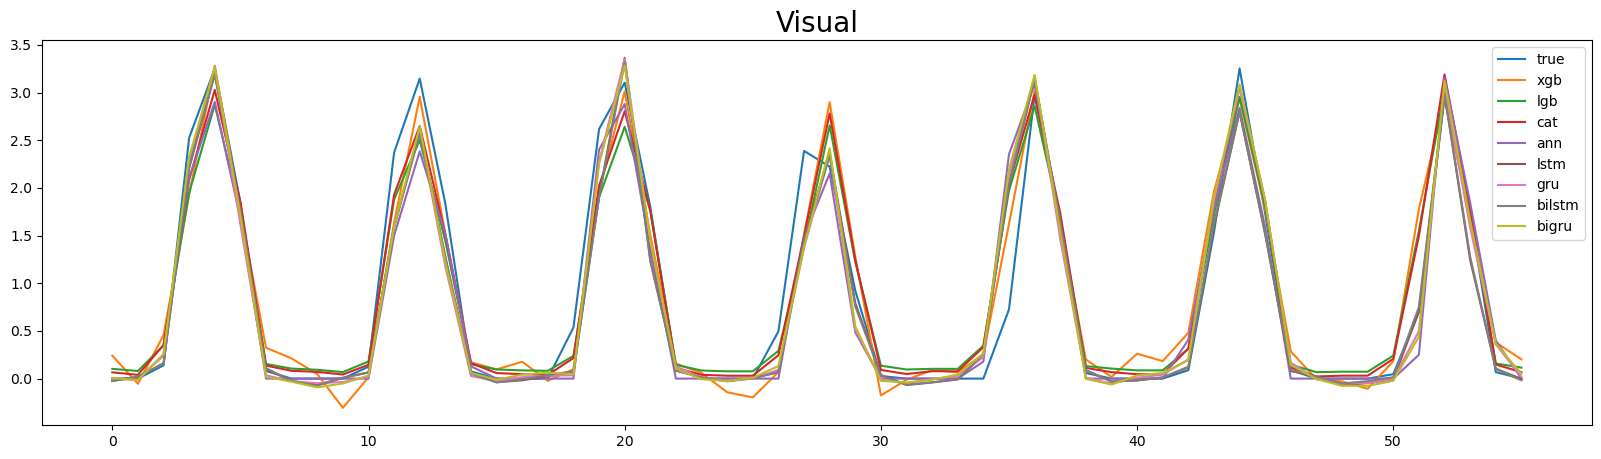

In [41]:
sns.reset_orig()
plt.figure(figsize = (20,5))
plt.title('Visual', fontsize = 20)
plt.plot(y_test_set[n], label = 'true')
plt.plot(xgb_pred[n], label = 'xgb')
plt.plot(lgb_pred[n], label = 'lgb')
plt.plot(cat_pred[n], label = 'cat')
plt.plot(ann_pred[n], label = 'ann')
plt.plot(lstm_pred[n], label = 'lstm')
plt.plot(gru_pred[n], label = 'gru')
plt.plot(bilstm_pred[n], label = 'bilstm')
plt.plot(bigru_pred[n], label = 'bigru')

plt.legend(fontsize = 10)
plt.show()

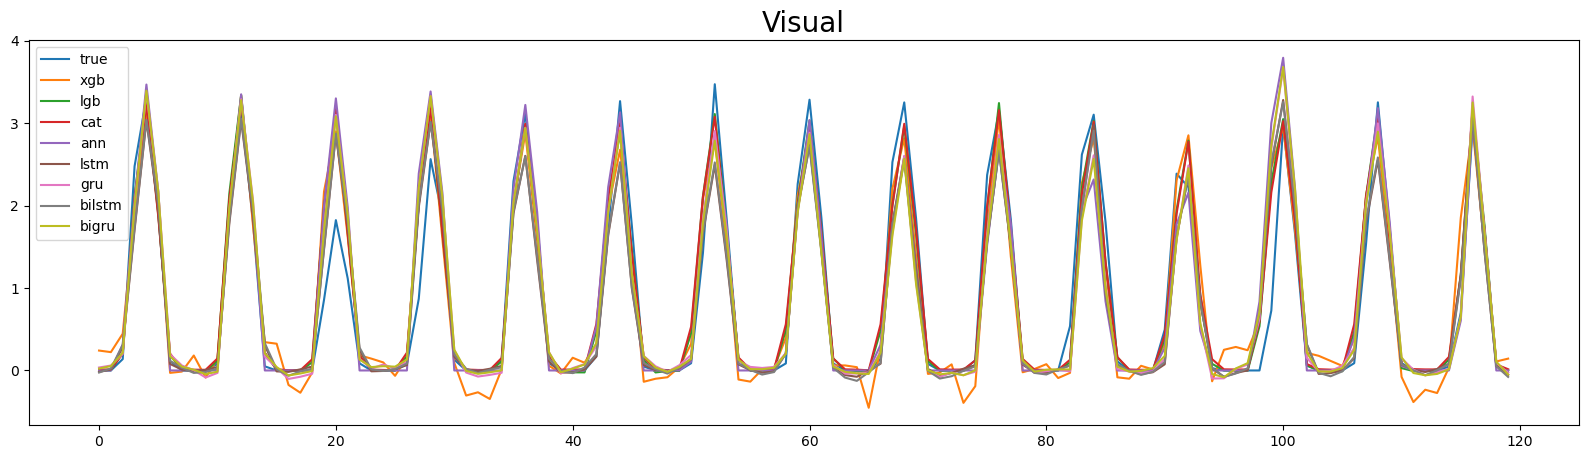

In [43]:
sns.reset_orig()
plt.figure(figsize = (20,5))
plt.title('Visual', fontsize = 20)
plt.plot(y_test_set[n], label = 'true')
plt.plot(xgb_pred[n], label = 'xgb')
plt.plot(lgb_pred[n], label = 'lgb')
plt.plot(cat_pred[n], label = 'cat')
plt.plot(ann_pred[n], label = 'ann')
plt.plot(lstm_pred[n], label = 'lstm')
plt.plot(gru_pred[n], label = 'gru')
plt.plot(bilstm_pred[n], label = 'bilstm')
plt.plot(bigru_pred[n], label = 'bigru')

plt.legend(fontsize = 10)
plt.show()

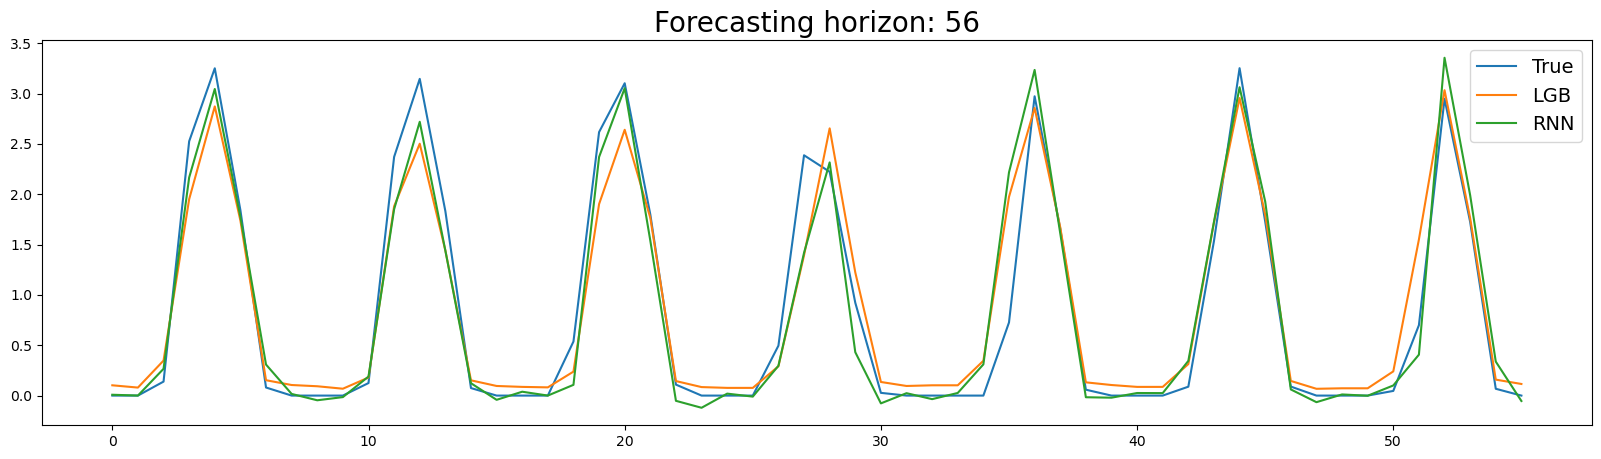

In [29]:
n = 0
sns.reset_orig()
plt.figure(figsize = (20,5))
plt.title('Forecasting horizon: 56', fontsize = 20)
plt.plot(y_test_set[n], label = 'True')
plt.plot(lgb_pred[n], label = 'LGB')
plt.plot(rnn_pred[n], label = 'RNN')

plt.legend(fontsize = 14)
plt.show()

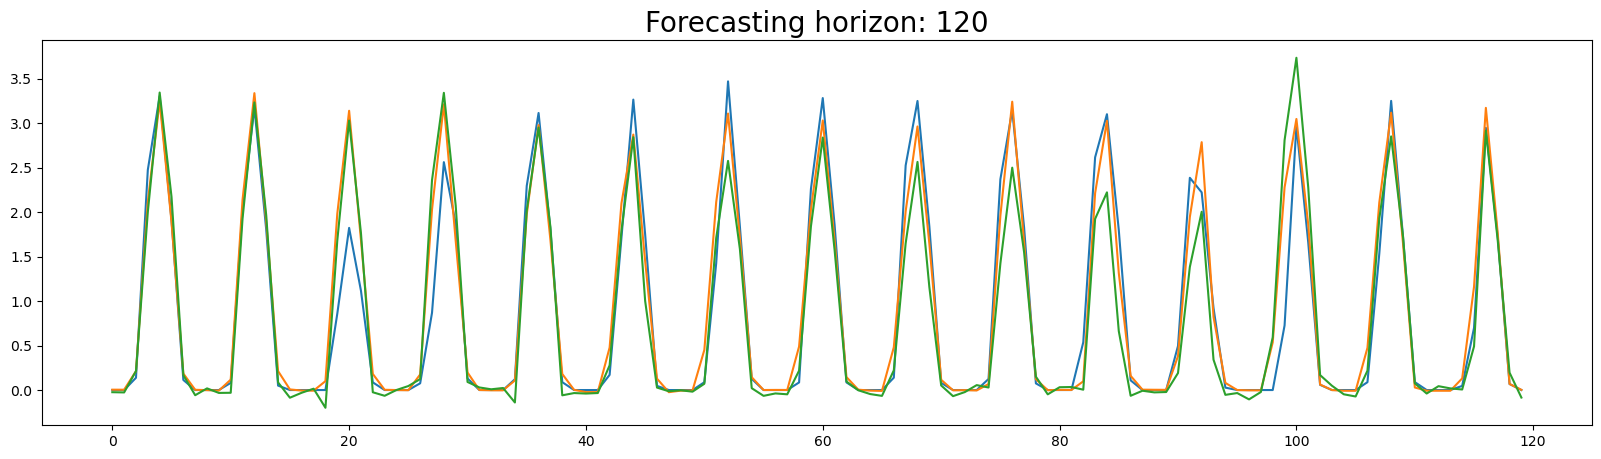

In [34]:
n = 1
sns.reset_orig()
plt.figure(figsize = (20,5))
plt.title('Forecasting horizon: 120', fontsize = 20)
plt.plot(y_test_set[n], label = 'True')
plt.plot(lgb_pred[n], label = 'LGB')
plt.plot(rnn_pred[n], label = 'RNN')

#plt.legend(fontsize = 14)
plt.show()

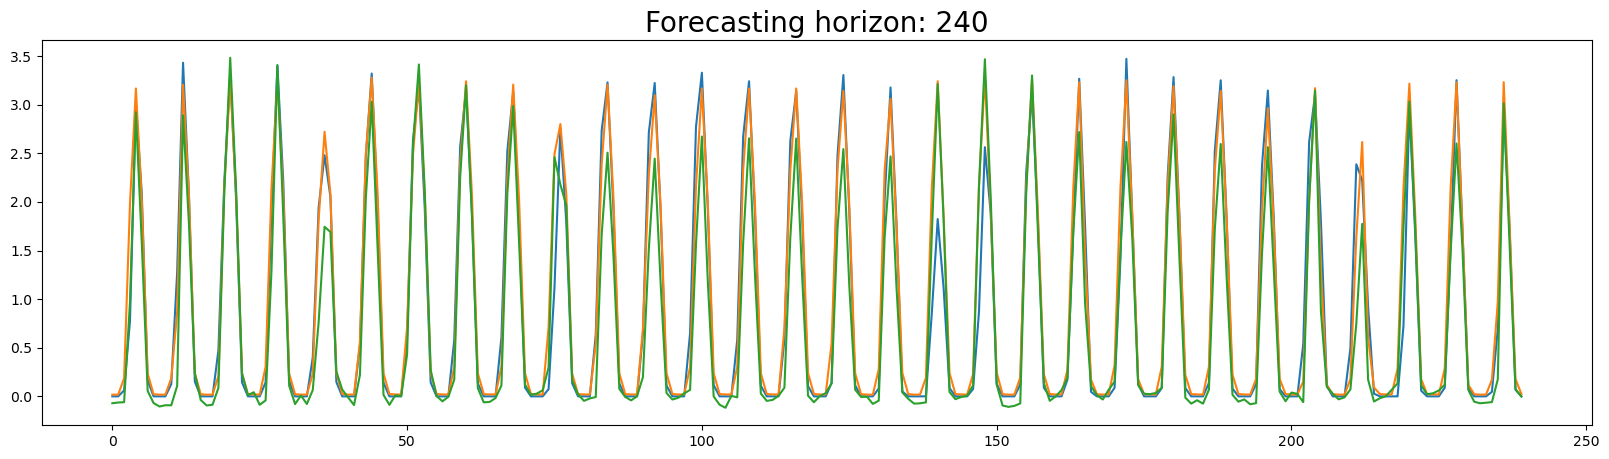

In [35]:
n = 2
sns.reset_orig()
plt.figure(figsize = (20,5))
plt.title('Forecasting horizon: 240', fontsize = 20)
plt.plot(y_test_set[n], label = 'True')
plt.plot(lgb_pred[n], label = 'LGB')
plt.plot(bigru_pred[n], label = 'RNN')

#plt.legend(fontsize = 14)
plt.show()

## Explanation for LightGBM

Build a regression model (not a time series forecasting model)

In [57]:
train = df[ : 2000]
rest = df[ 2000 :]
val = rest[ : int(len(rest)*0.5)] 
test = rest[int(len(rest)*0.5):] 

In [58]:
x_train = train.drop(columns = {'Power Generated'}, axis = 1)
y_train = train.loc[:, ['Power Generated']]

x_val = val.drop(columns = {'Power Generated'}, axis = 1)
y_val = val.loc[:, ['Power Generated']]

x_test = test.drop(columns = {'Power Generated'}, axis = 1)
y_test = test.loc[:, ['Power Generated']]

In [59]:
print(x_train.shape)
print(x_val.shape)
print(x_test.shape)

(2000, 9)
(460, 9)
(460, 9)


In [60]:
def objective(trial):
    """Define the objective function"""

    params = {
            'max_depth': trial.suggest_int('max_depth', 1, 9),
            'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 1.0),
            'n_estimators': trial.suggest_int('n_estimators', 50, 500),
            'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
            'subsample': trial.suggest_loguniform('subsample', 0.01, 1.0),
            'colsample_bytree': trial.suggest_loguniform('colsample_bytree', 0.01, 1.0),
            'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-8, 1.0),
            'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-8, 1.0),
        }
    
    # Fit the model
    optuna_model = lgb.LGBMRegressor(**params)
    optuna_model.fit(x_train, y_train)

    # Make predictions
    y_pred = optuna_model.predict(x_val)

    # Evaluate predictions
    score = r2_score(y_val, y_pred)
    return score

In [61]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

print('Number of finished trials: {}'.format(len(study.trials)))
print('Best trial:')
trial = study.best_trial

print('  Value: {}'.format(trial.value))
print('  Params: ')

for key, value in trial.params.items():
    print('    {}: {}'.format(key, value))

[I 2023-08-14 05:05:12,763] A new study created in memory with name: no-name-7868669d-d1f1-4e63-9d43-355ad96e9611
[I 2023-08-14 05:05:12,793] Trial 0 finished with value: 0.7844358086931705 and parameters: {'max_depth': 6, 'learning_rate': 0.09294147352868504, 'n_estimators': 75, 'min_child_weight': 6, 'subsample': 0.015576263243102347, 'colsample_bytree': 0.018981369218381228, 'reg_alpha': 0.00013195331293874575, 'reg_lambda': 9.15882184537585e-06}. Best is trial 0 with value: 0.7844358086931705.
[I 2023-08-14 05:05:12,821] Trial 1 finished with value: 0.823206595809284 and parameters: {'max_depth': 8, 'learning_rate': 0.12254445555939181, 'n_estimators': 91, 'min_child_weight': 8, 'subsample': 0.014369511013988251, 'colsample_bytree': 0.09391038230862278, 'reg_alpha': 0.001003342971427, 'reg_lambda': 0.01190166004934945}. Best is trial 1 with value: 0.823206595809284.
[I 2023-08-14 05:05:12,841] Trial 2 finished with value: 0.44215616658755874 and parameters: {'max_depth': 3, 'learni

[I 2023-08-14 05:05:13,939] Trial 21 finished with value: 0.8909290046806211 and parameters: {'max_depth': 2, 'learning_rate': 0.1655254622944498, 'n_estimators': 221, 'min_child_weight': 5, 'subsample': 0.26440330779346355, 'colsample_bytree': 0.9912709634967485, 'reg_alpha': 0.0879954654554381, 'reg_lambda': 1.9784097000058877e-06}. Best is trial 21 with value: 0.8909290046806211.
[I 2023-08-14 05:05:13,994] Trial 22 finished with value: 0.8882783918311206 and parameters: {'max_depth': 2, 'learning_rate': 0.14817742325493924, 'n_estimators': 224, 'min_child_weight': 5, 'subsample': 0.24544536255471705, 'colsample_bytree': 0.4485241304667498, 'reg_alpha': 0.10130275014067779, 'reg_lambda': 2.7523386603055933e-06}. Best is trial 21 with value: 0.8909290046806211.
[I 2023-08-14 05:05:14,051] Trial 23 finished with value: 0.8883329390006851 and parameters: {'max_depth': 2, 'learning_rate': 0.17806264292493915, 'n_estimators': 216, 'min_child_weight': 6, 'subsample': 0.24937850106083392, 

[I 2023-08-14 05:05:15,233] Trial 43 finished with value: 0.8918418332498819 and parameters: {'max_depth': 2, 'learning_rate': 0.19810345695775478, 'n_estimators': 199, 'min_child_weight': 7, 'subsample': 0.33393472683022696, 'colsample_bytree': 0.522637794181542, 'reg_alpha': 0.026805114153574002, 'reg_lambda': 6.070659748764978e-07}. Best is trial 24 with value: 0.9020537694541965.
[I 2023-08-14 05:05:15,288] Trial 44 finished with value: 0.8687439863769917 and parameters: {'max_depth': 1, 'learning_rate': 0.21277890405238406, 'n_estimators': 199, 'min_child_weight': 7, 'subsample': 0.3737278116956583, 'colsample_bytree': 0.542338741225393, 'reg_alpha': 6.588717924365081e-05, 'reg_lambda': 7.121859179705286e-07}. Best is trial 24 with value: 0.9020537694541965.
[I 2023-08-14 05:05:15,346] Trial 45 finished with value: 0.8715823041930936 and parameters: {'max_depth': 3, 'learning_rate': 0.26257073988274243, 'n_estimators': 120, 'min_child_weight': 6, 'subsample': 0.5244418585086146, '

[I 2023-08-14 05:05:16,591] Trial 65 finished with value: 0.9013765596933616 and parameters: {'max_depth': 2, 'learning_rate': 0.06230573632526436, 'n_estimators': 339, 'min_child_weight': 5, 'subsample': 0.13560296476907607, 'colsample_bytree': 0.881007848522392, 'reg_alpha': 0.36325982194654366, 'reg_lambda': 3.764655499500416e-07}. Best is trial 61 with value: 0.9043572255956519.
[I 2023-08-14 05:05:16,657] Trial 66 finished with value: 0.8595471269248434 and parameters: {'max_depth': 1, 'learning_rate': 0.05728447414320552, 'n_estimators': 335, 'min_child_weight': 5, 'subsample': 0.09251559842333501, 'colsample_bytree': 0.8870475889715345, 'reg_alpha': 0.3712443297879126, 'reg_lambda': 1.3329474418478484e-07}. Best is trial 61 with value: 0.9043572255956519.
[I 2023-08-14 05:05:16,768] Trial 67 finished with value: 0.8625909374736538 and parameters: {'max_depth': 7, 'learning_rate': 0.07059531661371166, 'n_estimators': 345, 'min_child_weight': 5, 'subsample': 0.1450730027638173, 'c

[I 2023-08-14 05:05:18,268] Trial 87 finished with value: 0.9047995329479538 and parameters: {'max_depth': 3, 'learning_rate': 0.02696398174647772, 'n_estimators': 265, 'min_child_weight': 1, 'subsample': 0.05648020915369468, 'colsample_bytree': 0.7430902108479954, 'reg_alpha': 0.07967874005826105, 'reg_lambda': 1.0077829493769885e-08}. Best is trial 81 with value: 0.9066970604236417.
[I 2023-08-14 05:05:18,339] Trial 88 finished with value: 0.9049264061992994 and parameters: {'max_depth': 3, 'learning_rate': 0.024108778092553924, 'n_estimators': 210, 'min_child_weight': 3, 'subsample': 0.05627596094150068, 'colsample_bytree': 0.7181995695466326, 'reg_alpha': 0.5521344576220711, 'reg_lambda': 1.0368644205453703e-08}. Best is trial 81 with value: 0.9066970604236417.
[I 2023-08-14 05:05:18,425] Trial 89 finished with value: 0.8835956308198318 and parameters: {'max_depth': 5, 'learning_rate': 0.02301508846191986, 'n_estimators': 211, 'min_child_weight': 3, 'subsample': 0.05008443582729121

Number of finished trials: 100
Best trial:
  Value: 0.9066970604236417
  Params: 
    max_depth: 2
    learning_rate: 0.04892189370094148
    n_estimators: 281
    min_child_weight: 4
    subsample: 0.0930110324752131
    colsample_bytree: 0.6172734635686603
    reg_alpha: 0.18363996444181563
    reg_lambda: 6.077384886064117e-08


In [63]:
model_lgb = lgb.LGBMRegressor(
                                                max_depth= 2,
                                                learning_rate= 0.04892189370094148,
                                                n_estimators= 281,
                                                min_child_weight= 4,
                                                subsample=0.0930110324752131,
                                                colsample_bytree= 0.6172734635686603,
                                                reg_alpha= 0.18363996444181563,
                                                reg_lambda= 6.077384886064117e-08
)

In [64]:
model_lgb.fit(x_train, y_train, eval_set=[(x_val, y_val)])
y_pred_val = model_lgb.predict(x_val)
score_lgb = r2_score(y_val, y_pred_val)

[1]	valid_0's l2: 1.57654
[2]	valid_0's l2: 1.48154
[3]	valid_0's l2: 1.39445
[4]	valid_0's l2: 1.31376
[5]	valid_0's l2: 1.22933
[6]	valid_0's l2: 1.1629
[7]	valid_0's l2: 1.12653
[8]	valid_0's l2: 1.06592
[9]	valid_0's l2: 0.999295
[10]	valid_0's l2: 0.942229
[11]	valid_0's l2: 0.889305
[12]	valid_0's l2: 0.838022
[13]	valid_0's l2: 0.811694
[14]	valid_0's l2: 0.772149
[15]	valid_0's l2: 0.735805
[16]	valid_0's l2: 0.703118
[17]	valid_0's l2: 0.67178
[18]	valid_0's l2: 0.642538
[19]	valid_0's l2: 0.608269
[20]	valid_0's l2: 0.577759
[21]	valid_0's l2: 0.554538
[22]	valid_0's l2: 0.54024
[23]	valid_0's l2: 0.518432
[24]	valid_0's l2: 0.505577
[25]	valid_0's l2: 0.482278
[26]	valid_0's l2: 0.466272
[27]	valid_0's l2: 0.448785
[28]	valid_0's l2: 0.438982
[29]	valid_0's l2: 0.425598
[30]	valid_0's l2: 0.416919
[31]	valid_0's l2: 0.402042
[32]	valid_0's l2: 0.385678
[33]	valid_0's l2: 0.370726
[34]	valid_0's l2: 0.363975
[35]	valid_0's l2: 0.357504
[36]	valid_0's l2: 0.351162
[37]	valid_0

In [65]:
score_lgb

0.9066970604236417

In [66]:
pred = model_lgb.predict(x_test)
r2 = r2_score(pred, y_test)
mse = mean_squared_error(pred, y_test)

print('R2: ', r2, '  ;  ', 'MSE: ', mse)

R2:  0.9230971464330272   ;   MSE:  0.09731775720175012


Interpret models for influential factor analysis

In [67]:
import shap

In [68]:
exp_lgb = shap.Explainer(model_lgb)

In [69]:
shap_values_lgb = exp_lgb(x_train)

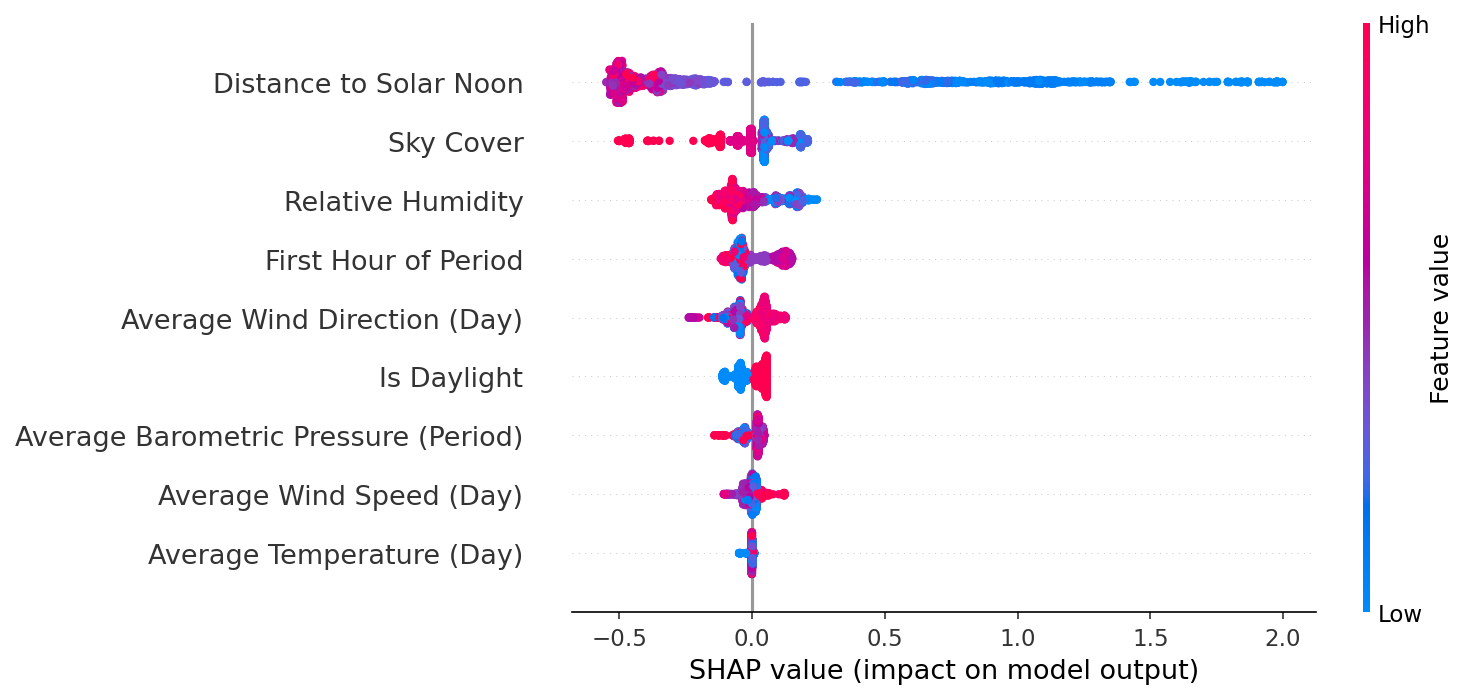

In [84]:
plt.figure(figsize = (5,4), dpi=150)
shap.plots.beeswarm(shap_values_lgb)

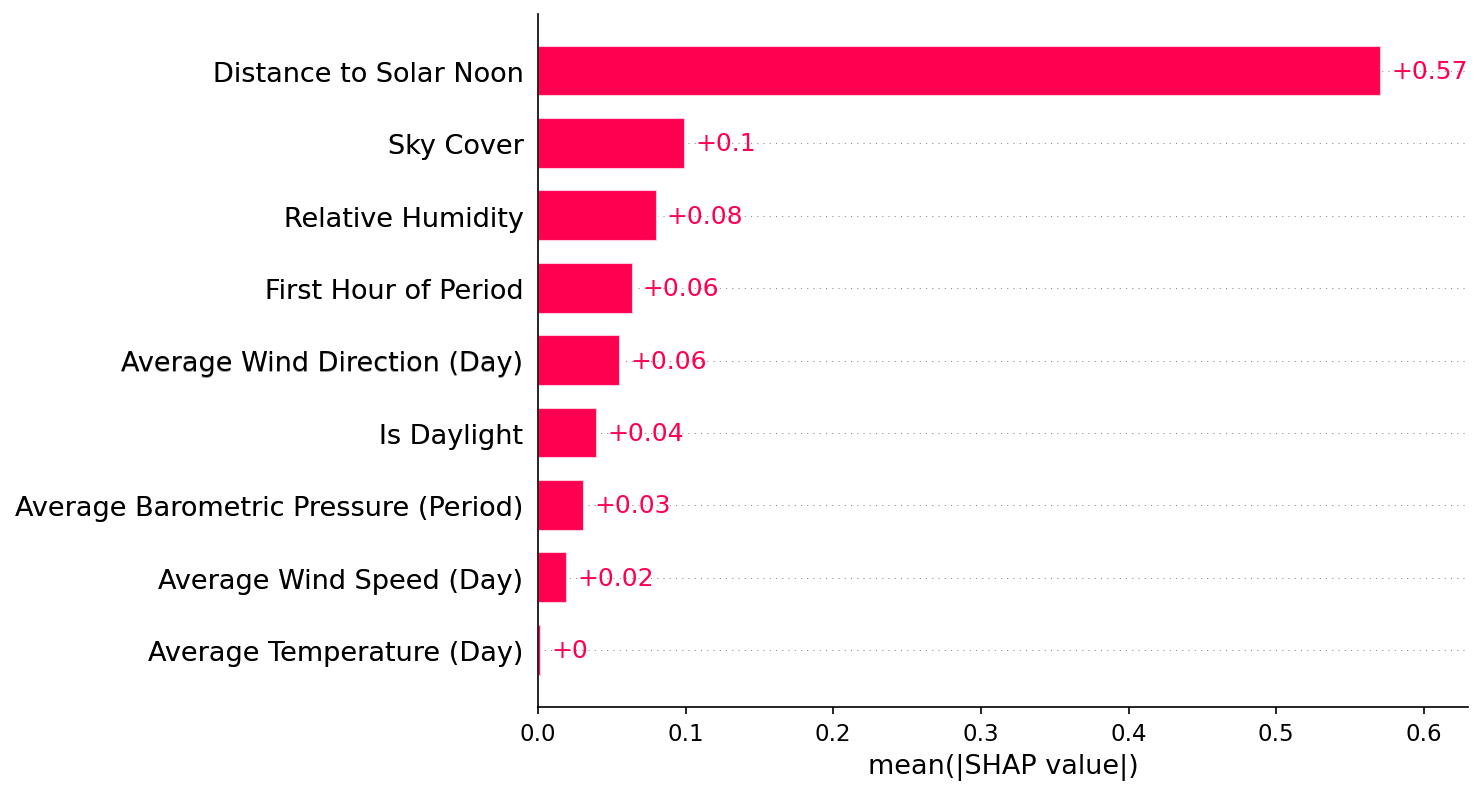

In [71]:
plt.figure(figsize = (5,4), dpi=150)
shap.plots.bar(shap_values_lgb)

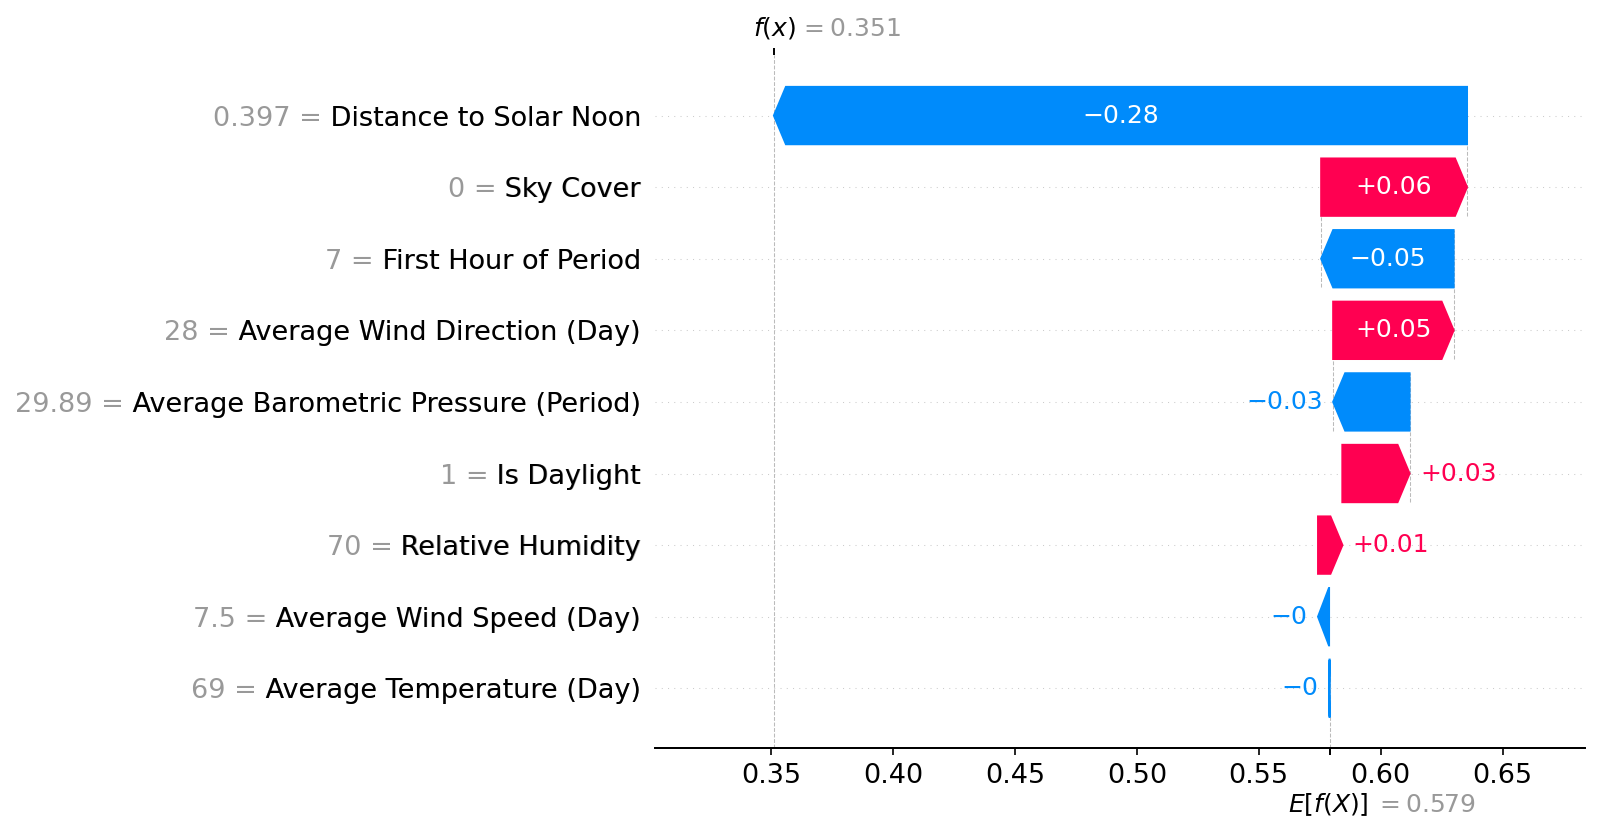

In [72]:
plt.figure(figsize = (5,4), dpi=150)
shap.plots.waterfall(shap_values_lgb[2])

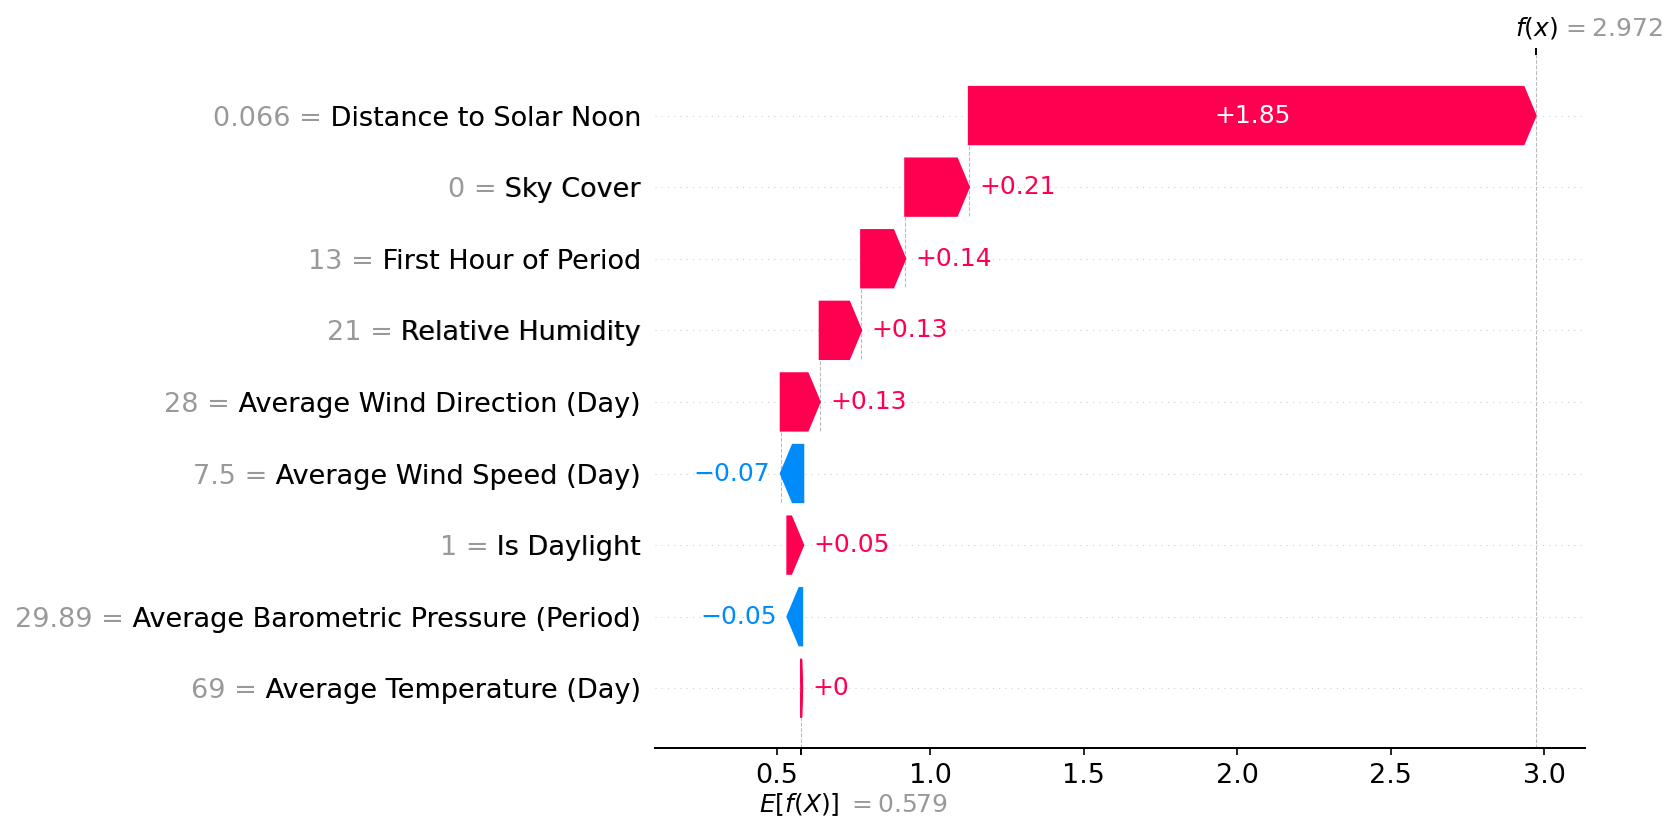

In [73]:
plt.figure(figsize = (5,4), dpi=150)
shap.plots.waterfall(shap_values_lgb[4])

<Figure size 750x600 with 0 Axes>

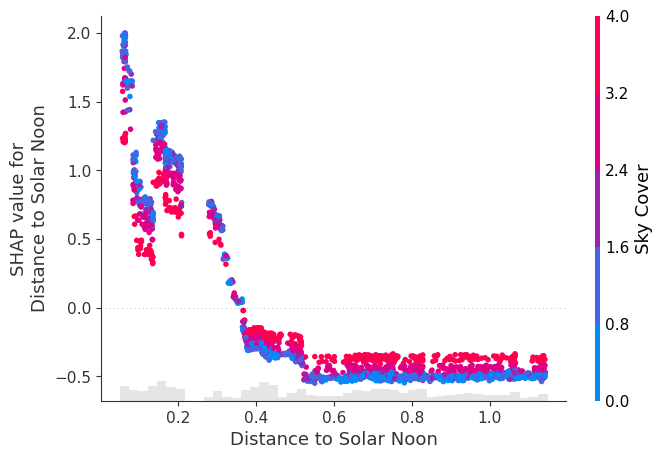

In [74]:
plt.figure(figsize = (5,4), dpi=150)
shap.plots.scatter(shap_values_lgb[:,"Distance to Solar Noon"], color=shap_values_lgb)

<Figure size 750x600 with 0 Axes>

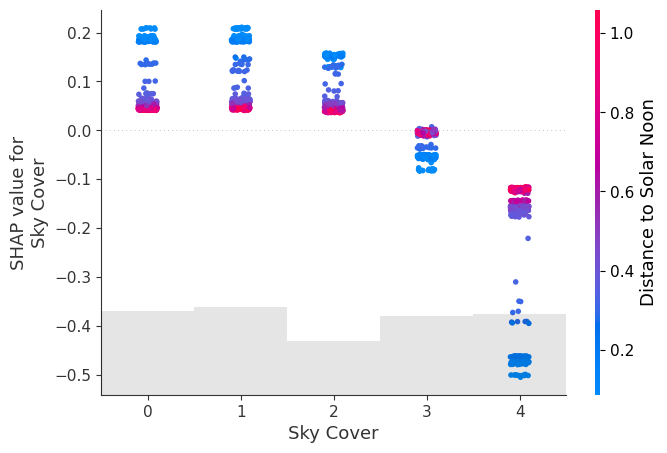

In [75]:
plt.figure(figsize = (5,4), dpi=150)
shap.plots.scatter(shap_values_lgb[:,"Sky Cover"], color=shap_values_lgb)

<Figure size 750x600 with 0 Axes>

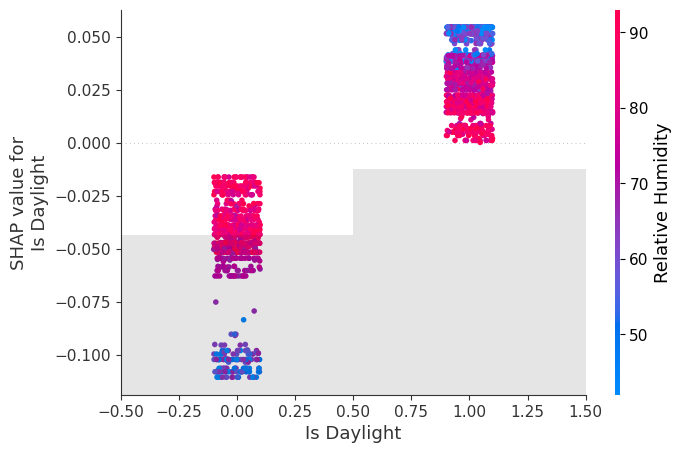

In [76]:
plt.figure(figsize = (5,4), dpi=150)
shap.plots.scatter(shap_values_lgb[:,"Is Daylight"], color=shap_values_lgb)

<Figure size 750x600 with 0 Axes>

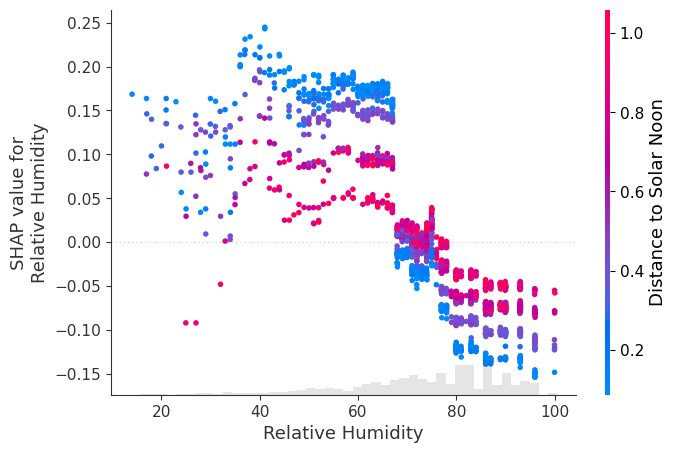

In [82]:
plt.figure(figsize = (5,4), dpi=150)
shap.plots.scatter(shap_values_lgb[:,"Relative Humidity"], color=shap_values_lgb)

<Figure size 750x600 with 0 Axes>

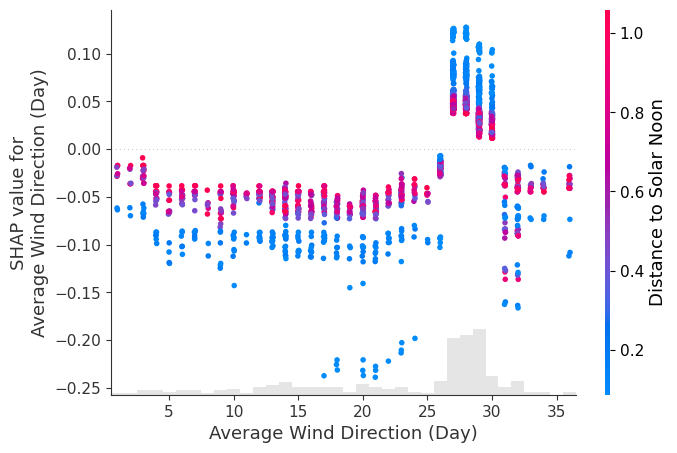

In [78]:
plt.figure(figsize = (5,4), dpi=150)
shap.plots.scatter(shap_values_lgb[:,"Average Wind Direction (Day)"], color=shap_values_lgb)

<Figure size 750x600 with 0 Axes>

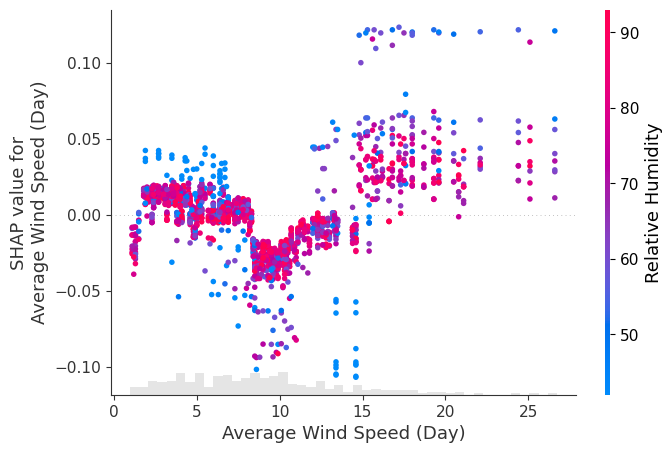

In [79]:
plt.figure(figsize = (5,4), dpi=150)
shap.plots.scatter(shap_values_lgb[:,"Average Wind Speed (Day)"], color=shap_values_lgb)

<Figure size 750x600 with 0 Axes>

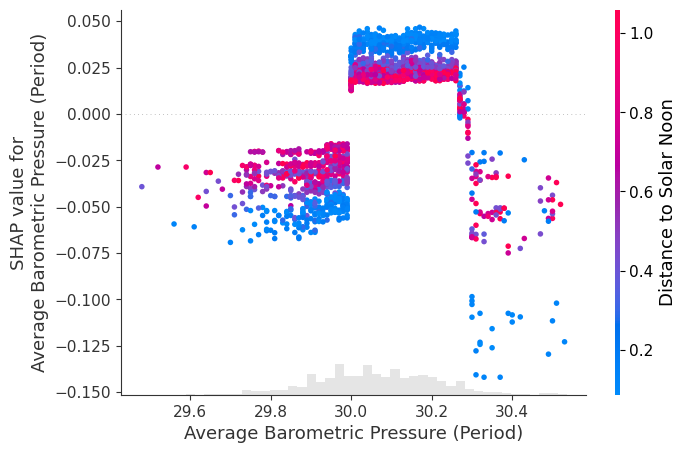

In [80]:
plt.figure(figsize = (5,4), dpi=150)
shap.plots.scatter(shap_values_lgb[:,"Average Barometric Pressure (Period)"], color=shap_values_lgb)

<Figure size 750x600 with 0 Axes>

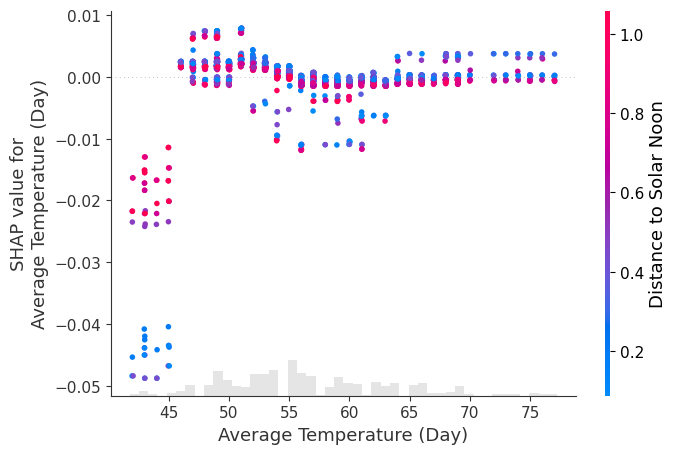

In [81]:
plt.figure(figsize = (5,4), dpi=150)
shap.plots.scatter(shap_values_lgb[:,"Average Temperature (Day)"], color=shap_values_lgb)